Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           567 non-null    object 
 1   Teams_Result   567 non-null    object 
 2   JerseyNo       567 non-null    int64  
 3   Player         567 non-null    object 
 4   Position       567 non-null    object 
 5   Goals          567 non-null    int64  
 6   Penalties      567 non-null    int64  
 7   YellowCards    567 non-null    int64  
 8   RedCards       567 non-null    int64  
 9   IsSubstitute   567 non-null    int64  
 10  Temperature    567 non-null    float64
 11  Humidity       567 non-null    float64
 12  Precipitation  567 non-null    float64
 13  WindSpeed      567 non-null    float64
 14  Pressure       567 non-null    float64
dtypes: float64(5), int64(6), object(4)
memory usage: 66.6+ KB
None

First 5 rows of the dataset:
         Date                      

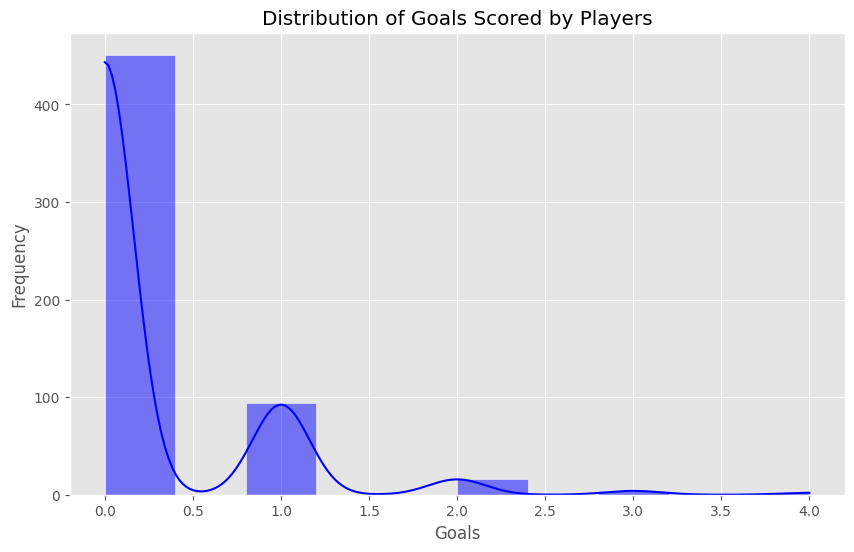

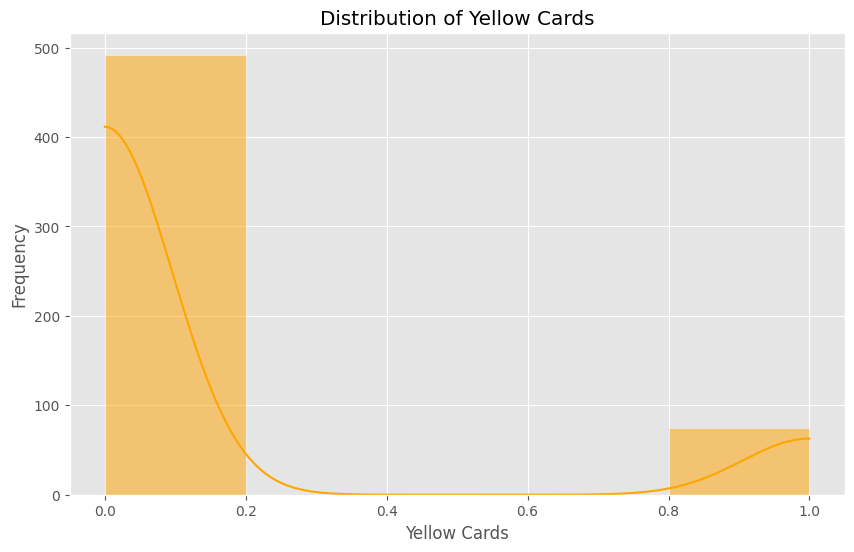

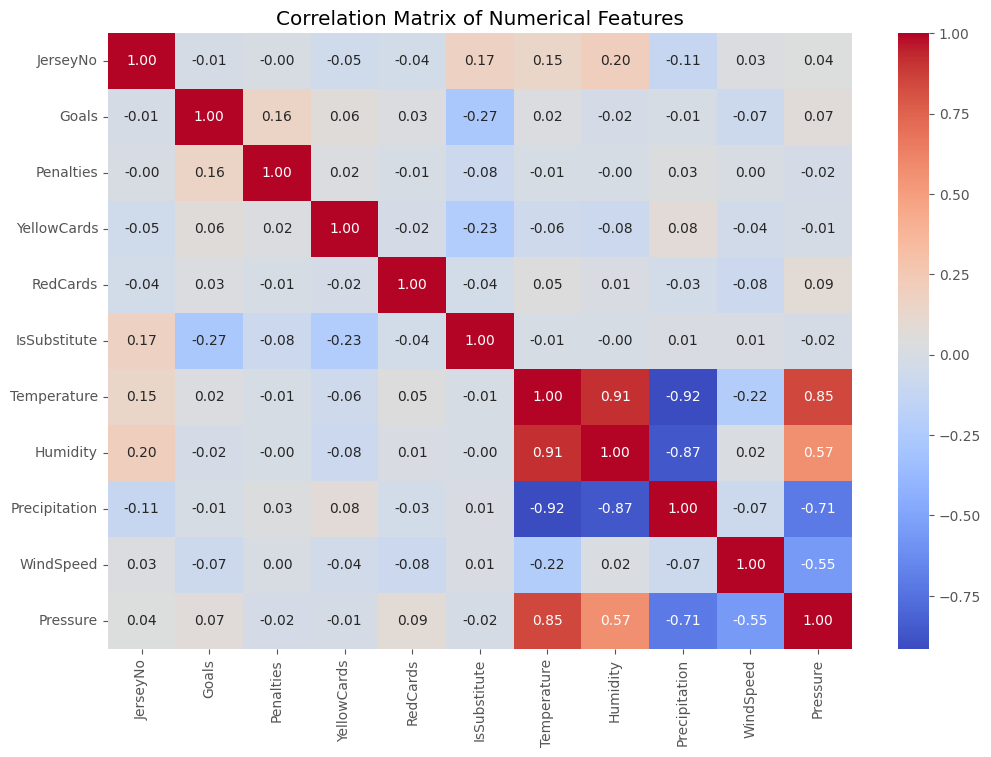

In [1]:

# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setting plot style for better visualization
# Using 'ggplot' as a fallback style from Matplotlib
plt.style.use('ggplot')

# Loading the dataset
# Ensure the CSV file is in the same directory as your notebook or provide the full path
try:
    data = pd.read_csv('dataset/final_merge_main_dataset.csv')
except FileNotFoundError:
    print("Error: The file 'final_merge_main_dataset.csv' was not found. Please ensure the file is in the correct directory.")
    raise

# Displaying basic information about the dataset
print("Dataset Info:")
print(data.info())
print("\nFirst 5 rows of the dataset:")
print(data.head())

# Checking for missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Checking for duplicate rows
print("\nNumber of duplicate rows:")
print(data.duplicated().sum())

# Basic statistical summary
print("\nStatistical Summary:")
print(data.describe())

# Visualizing distribution of Goals
plt.figure(figsize=(10, 6))
sns.histplot(data['Goals'], bins=10, kde=True, color='blue')
plt.title('Distribution of Goals Scored by Players')
plt.xlabel('Goals')
plt.ylabel('Frequency')
plt.show()

# Visualizing distribution of Yellow Cards
plt.figure(figsize=(10, 6))
sns.histplot(data['YellowCards'], bins=5, kde=True, color='orange')
plt.title('Distribution of Yellow Cards')
plt.xlabel('Yellow Cards')
plt.ylabel('Frequency')
plt.show()

# Correlation matrix for numerical features
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()


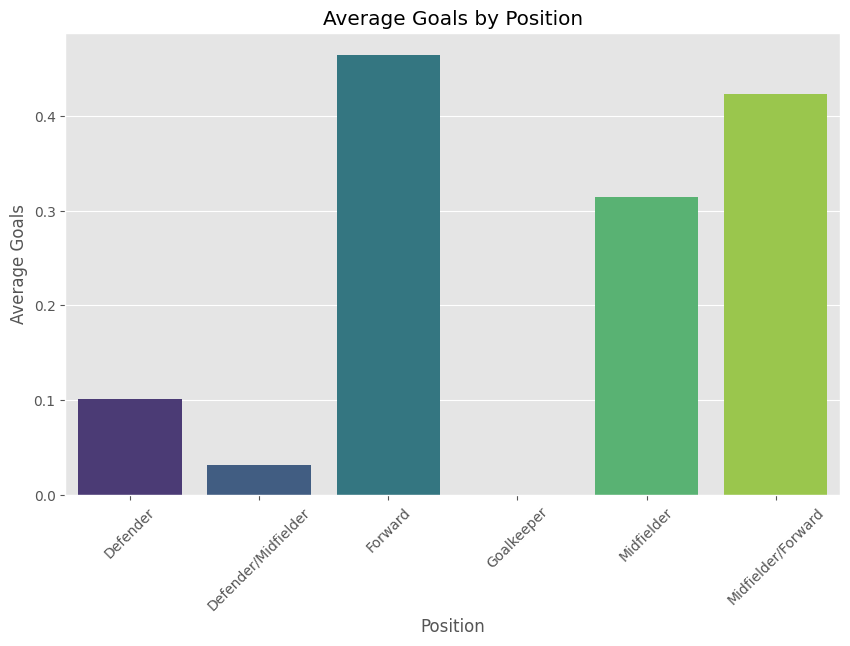

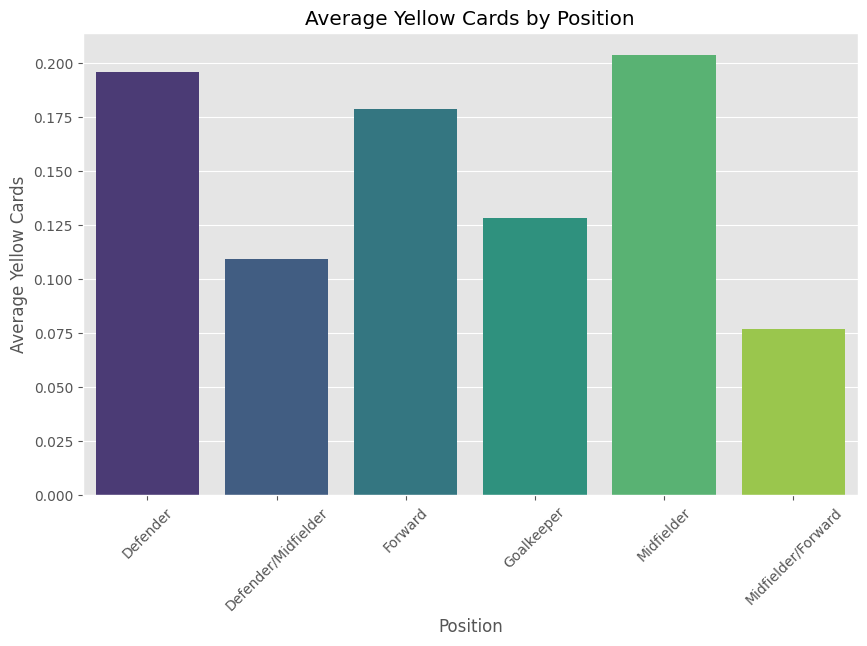

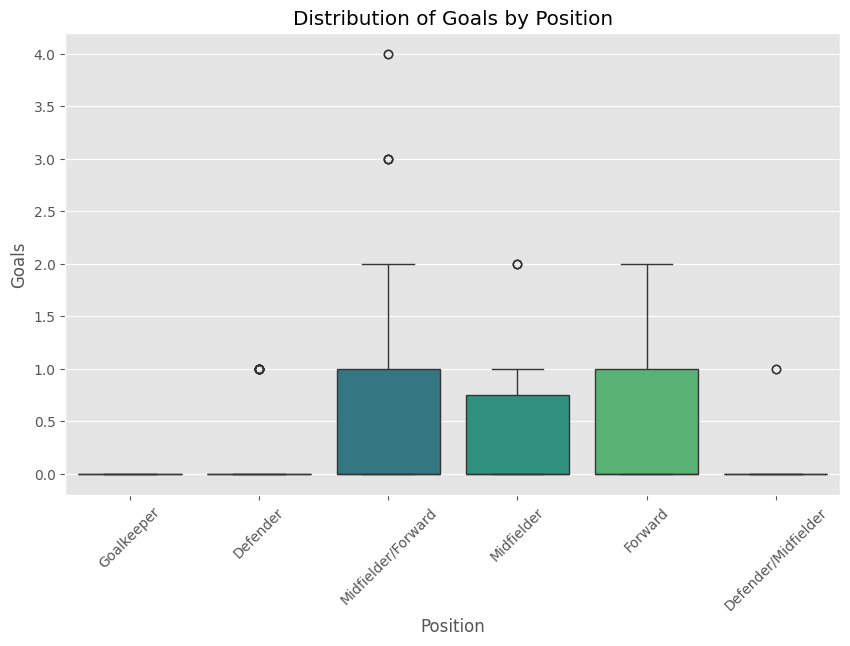

In [2]:


# Loading the dataset
data = pd.read_csv('dataset/final_merge_main_dataset.csv')

# Grouping data by Position and calculating mean performance
position_stats = data.groupby('Position').agg({
    'Goals': 'mean',
    'YellowCards': 'mean',
    'RedCards': 'mean'
}).reset_index()

# Visualizing mean performance by Position
plt.figure(figsize=(10, 6))
sns.barplot(x='Position', y='Goals', hue='Position', data=position_stats, palette='viridis', legend=False)
plt.title('Average Goals by Position')
plt.xlabel('Position')
plt.ylabel('Average Goals')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Position', y='YellowCards', hue='Position', data=position_stats, palette='viridis', legend=False)
plt.title('Average Yellow Cards by Position')
plt.xlabel('Position')
plt.ylabel('Average Yellow Cards')
plt.xticks(rotation=45)
plt.show()

# Box plot for Goals by Position
plt.figure(figsize=(10, 6))
sns.boxplot(x='Position', y='Goals', hue='Position', data=data, palette='viridis', legend=False)
plt.title('Distribution of Goals by Position')
plt.xlabel('Position')
plt.ylabel('Goals')
plt.xticks(rotation=45)
plt.show()


In [3]:

from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Loading the dataset
data = pd.read_csv('dataset/final_merge_main_dataset.csv')

# 1. Encoding categorical variables
# Encoding Position
label_encoder = LabelEncoder()
data['Position_Encoded'] = label_encoder.fit_transform(data['Position'])

# Extracting match result from Teams_Result (Win, Loss, Draw)
def extract_result(row):
    parts = row['Teams_Result'].split(' ')
    score = None
    for i in range(len(parts) - 1, -1, -1):
        if ':' in parts[i]:
            score = parts[i]
            break
    if score is None:
        print(f"Warning: No valid score found in {row['Teams_Result']}")
        return 'Unknown'
    try:
        team1_score, team2_score = map(int, score.split(':'))
        if 'Manchester City' in ' '.join(parts[:i]):
            if team1_score > team2_score:
                return 'Win'
            elif team1_score < team2_score:
                return 'Loss'
            else:
                return 'Draw'
        else:
            if team1_score < team2_score:
                return 'Win'
            elif team1_score > team2_score:
                return 'Loss'
            else:
                return 'Draw'
    except ValueError as e:
        print(f"Error processing score {score} in {row['Teams_Result']}: {e}")
        return 'Unknown'

data['Match_Result'] = data.apply(extract_result, axis=1)
data['Match_Result_Encoded'] = label_encoder.fit_transform(data['Match_Result'])

# 2. Creating new features
# Average goals per player up to the current match
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(['Player', 'Date'])
data['Player_Avg_Goals'] = data.groupby('Player')['Goals'].expanding().mean().reset_index(level=0, drop=True)
data['Player_Avg_Goals'] = data['Player_Avg_Goals'].shift(1)  # Shift to avoid data leakage
data['Player_Avg_Goals'] = data.groupby('Player')['Player_Avg_Goals'].ffill()  # Updated to remove warning

# Interaction between IsSubstitute and Goals
data['Substitute_Goals_Interaction'] = data['IsSubstitute'] * data['Goals']

# Combined weather feature (Temperature * Humidity as a proxy for "weather harshness")
data['Weather_Condition'] = data['Temperature'] * data['Humidity']

# 3. Normalizing numerical features
scaler = MinMaxScaler()
numerical_cols = ['Temperature', 'Humidity', 'Precipitation', 'WindSpeed', 'Pressure', 'Weather_Condition']
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Display the first few rows of the updated dataset
print("First 5 rows of the updated dataset:")
print(data.head())

# Save the updated dataset for modeling
data.to_csv('dataset/processed_dataset.csv', index=False)
print("Processed dataset saved as 'processed_dataset.csv'")

First 5 rows of the updated dataset:
          Date                        Teams_Result  JerseyNo           Player  \
18  2021-08-21    Manchester City 5:0 Norwich City        14  Aymeric Laporte   
48  2021-09-11  Leicester City 0:1 Manchester City        14  Aymeric Laporte   
63  2021-09-18     Manchester City 0:0 Southampton        14  Aymeric Laporte   
94  2021-10-03       Liverpool 2:2 Manchester City        14  Aymeric Laporte   
102 2021-10-03       Liverpool 2:2 Manchester City        14  Aymeric Laporte   

     Position  Goals  Penalties  YellowCards  RedCards  IsSubstitute  ...  \
18   Defender      0          0            1         0             0  ...   
48   Defender      1          0            1         0             0  ...   
63   Defender      0          0            1         0             0  ...   
94   Defender      0          0            0         0             0  ...   
102  Defender      0          0            0         0             1  ...   

     Humidity

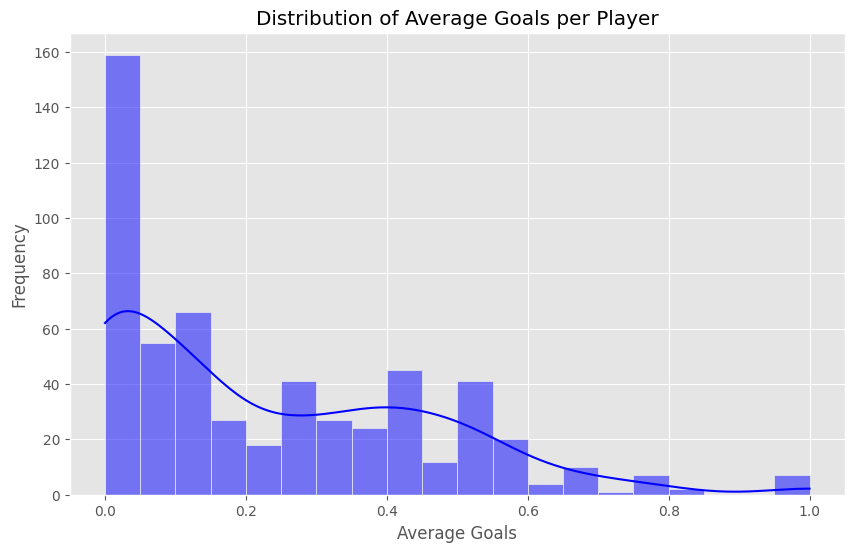

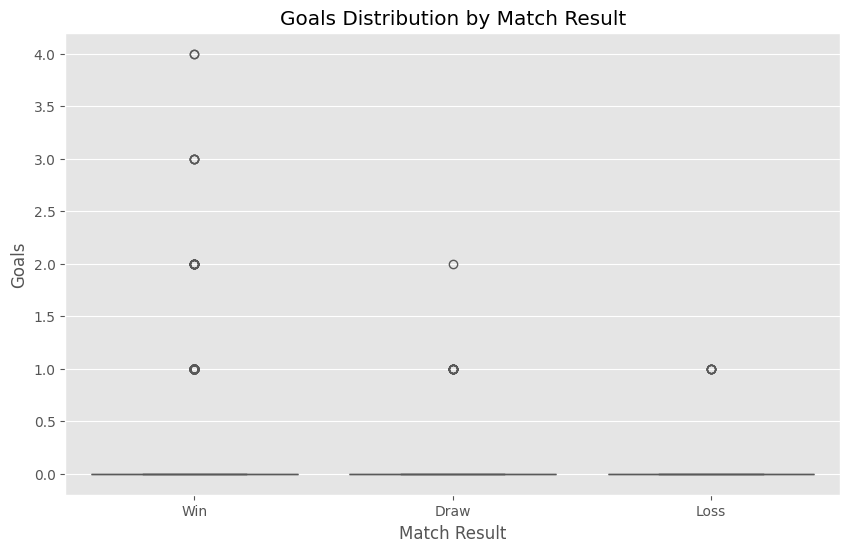

In [4]:

# Plotting distribution of Player_Avg_Goals
plt.figure(figsize=(10, 6))
sns.histplot(data['Player_Avg_Goals'].dropna(), bins=20, kde=True, color='blue')
plt.title('Distribution of Average Goals per Player')
plt.xlabel('Average Goals')
plt.ylabel('Frequency')
plt.show()

# Box plot of Goals by Match_Result
plt.figure(figsize=(10, 6))
sns.boxplot(x='Match_Result', y='Goals', hue='Match_Result', data=data, palette='Set2', legend=False)
plt.title('Goals Distribution by Match Result')
plt.xlabel('Match Result')
plt.ylabel('Goals')
plt.show()


In [8]:

# Load the dataset
data = pd.read_csv('dataset/final_merge_main_dataset.csv')

# Function to extract Manchester City goals
def get_mc_goals(teams_result):
    parts = teams_result.split(' ')
    score = next((p for p in parts if ':' in p), None)
    if score:
        team1_score, team2_score = map(int, score.split(':'))
        if 'Manchester City' in parts[0]:
            return team1_score
        else:
            return team2_score
    return 0

# Add total goals per match for Manchester City
data['MC_Goals'] = data['Teams_Result'].apply(get_mc_goals)

# Create a unique match identifier
data['Match_ID'] = data.groupby(['Date', 'Teams_Result']).ngroup()

# Calculate total goals by players per match
match_goals = data.groupby('Match_ID').agg({
    'MC_Goals': 'first',
    'Goals': 'sum'
}).reset_index()

# Check if the total goals by players match the MC goals
match_goals['Goals_Match'] = match_goals['MC_Goals'] == match_goals['Goals']

# Results
total_matches = len(match_goals)
matches_correct = match_goals['Goals_Match'].sum()
print(f"Total number of matches: {total_matches}")
print(f"Number of matches where goals match: {matches_correct}")
print(f"Percentage of matches with correct goals: {matches_correct / total_matches * 100:.2f}%")

# Display mismatches
mismatches = match_goals[~match_goals['Goals_Match']]
print("\nMismatches (first 5 rows):")
print(mismatches.head(38))


Total number of matches: 38
Number of matches where goals match: 2
Percentage of matches with correct goals: 5.26%

Mismatches (first 5 rows):
    Match_ID  MC_Goals  Goals  Goals_Match
0          0         0      2        False
1          1         0      5        False
2          2         0      5        False
3          3         1      2        False
4          4         0      1        False
5          5         1      2        False
6          6         2      3        False
7          7         0      3        False
8          8         4      6        False
9          9         2      1        False
10        10         2      1        False
11        11         0      2        False
12        12         1      3        False
13        13         2      3        False
14        14         3      4        False
15        15         0      2        False
16        16         0      6        False
18        18         3      7        False
19        19         1      2        Fal

In [9]:
player_stats = pd.read_csv('dataset/manchester_city_player_stats.csv')
total_goals_stats = player_stats['Goals'].sum()
print(f"Total goals in player stats: {total_goals_stats}")

Total goals in player stats: 146


In [10]:
goals_by_position = player_stats.groupby('Position')['Goals'].sum()
print("Total goals by position in player stats:")
print(goals_by_position)

Total goals by position in player stats:
Position
Defender               15
Defender/Midfielder     2
Forward                13
Goalkeeper              0
Midfielder             17
Midfielder/Forward     99
Name: Goals, dtype: int64


In [11]:
total_goals_main = data['Goals'].sum()
print(f"Total goals in main dataset: {total_goals_main}")

Total goals in main dataset: 146


In [12]:
goals_by_position_main = data.groupby('Position')['Goals'].sum()
print("Total goals by position in main dataset:")
print(goals_by_position_main)

Total goals by position in main dataset:
Position
Defender               15
Defender/Midfielder     2
Forward                13
Goalkeeper              0
Midfielder             17
Midfielder/Forward     99
Name: Goals, dtype: int64


In [13]:

# Load the dataset
data = pd.read_csv('dataset/final_merge_main_dataset.csv')

# Extract Manchester City goals
def get_mc_goals(teams_result):
    parts = teams_result.split(' ')
    score = next((p for p in parts if ':' in p), None)
    if score:
        team1_score, team2_score = map(int, score.split(':'))
        if 'Manchester City' in parts[0]:
            return team1_score
        else:
            return team2_score
    return 0

data['MC_Goals'] = data['Teams_Result'].apply(get_mc_goals)

# Create a unique match identifier
data['Match_ID'] = data.groupby(['Date', 'Teams_Result']).ngroup()

# Function to adjust goals per match
def adjust_goals_per_match(group):
    total_mc_goals = group['MC_Goals'].iloc[0]
    current_goals = group['Goals'].sum()
    
    # Reset Goals to 0 if MC_Goals is 0
    if total_mc_goals == 0:
        group['Goals'] = 0
        return group
    
    # Adjust if current goals don't match MC_Goals
    if current_goals != total_mc_goals:
        # Prioritize Forward and Midfielder/Forward
        forwards = group[group['Position'].isin(['Forward', 'Midfielder/Forward'])]
        others = group[~group['Position'].isin(['Forward', 'Midfielder/Forward'])]
        
        if current_goals < total_mc_goals:
            # Add goals to forwards
            remaining = total_mc_goals - current_goals
            if not forwards.empty:
                goals_per_forward = remaining // len(forwards)
                extra = remaining % len(forwards)
                forwards['Goals'] = forwards['Goals'] + goals_per_forward
                forwards.iloc[:extra, forwards.columns.get_loc('Goals')] += 1
        elif current_goals > total_mc_goals:
            # Remove excess goals from non-forwards
            excess = current_goals - total_mc_goals
            if not others.empty:
                goals_to_remove = excess // len(others)
                extra = excess % len(others)
                others['Goals'] = others['Goals'] - goals_to_remove
                others.iloc[:extra, others.columns.get_loc('Goals')] -= 1
                others['Goals'] = others['Goals'].clip(lower=0)
        
        # Combine and ensure total matches
        group = pd.concat([forwards, others])
        group['Goals'] = group['Goals'].clip(lower=0)
        total_adjusted = group['Goals'].sum()
        if total_adjusted != total_mc_goals:
            diff = total_mc_goals - total_adjusted
            if diff > 0 and not forwards.empty:
                forwards.iloc[:diff, forwards.columns.get_loc('Goals')] += 1
            group = pd.concat([forwards, others])
    
    return group

# Apply the adjustment
data = data.groupby('Match_ID').apply(adjust_goals_per_match).reset_index(drop=True)

# Verify the adjustment
data['Match_ID'] = data.groupby(['Date', 'Teams_Result']).ngroup()  # Recalculate Match_ID
match_goals = data.groupby('Match_ID').agg({
    'MC_Goals': 'first',
    'Goals': 'sum'
}).reset_index()
match_goals['Goals_Match'] = match_goals['MC_Goals'] == match_goals['Goals']

# Results
total_matches = len(match_goals)
matches_correct = match_goals['Goals_Match'].sum()
print(f"Total number of matches: {total_matches}")
print(f"Number of matches where goals match: {matches_correct}")
print(f"Percentage of matches with correct goals: {matches_correct / total_matches * 100:.2f}%")

# Display first 5 rows of corrected dataset
print("\nFirst 5 rows of corrected dataset:")
print(data.head())

# Save the corrected dataset
data.to_csv('final_corrected_dataset.csv', index=False)
print("Corrected dataset saved as 'final_corrected_dataset.csv'")


Total number of matches: 38
Number of matches where goals match: 18
Percentage of matches with correct goals: 47.37%

First 5 rows of corrected dataset:
         Date                           Teams_Result  JerseyNo  \
0  2021-08-15  Tottenham Hotspur 1:0 Manchester City        13   
1  2021-08-15  Tottenham Hotspur 1:0 Manchester City        79   
2  2021-08-15  Tottenham Hotspur 1:0 Manchester City        22   
3  2021-08-15  Tottenham Hotspur 1:0 Manchester City        94   
4  2021-08-15  Tottenham Hotspur 1:0 Manchester City        97   

                Player    Position  Goals  Penalties  YellowCards  RedCards  \
0         Zack Steffen  Goalkeeper      0          0            0         0   
1      Luke Mbete-Tabu    Defender      0          0            0         0   
2       Benjamin Mendy    Defender      0          0            0         0   
3         Finley Burns    Defender      0          0            0         0   
4  Josh Wilson-Esbrand    Defender      0          0   

/var/folders/c6/kh1v5smn18l3tbcsjpvvqv1h0000gn/T/ipykernel_4363/997993954.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('Match_ID').apply(adjust_goals_per_match).reset_index(drop=True)


In [14]:

# Load the corrected dataset
data = pd.read_csv('final_corrected_dataset.csv')

# Create Match_ID
data['Match_ID'] = data.groupby(['Date', 'Teams_Result']).ngroup()

# Calculate total goals per match
match_goals = data.groupby('Match_ID').agg({
    'MC_Goals': 'first',
    'Goals': 'sum'
}).reset_index()
match_goals['Goals_Match'] = match_goals['MC_Goals'] == match_goals['Goals']

# Display mismatches
mismatches = match_goals[~match_goals['Goals_Match']]
print("Mismatches:")
print(mismatches)


Mismatches:
    Match_ID  MC_Goals  Goals  Goals_Match
3          3         1      2        False
5          5         1      2        False
6          6         2      3        False
8          8         4      6        False
12        12         1      3        False
13        13         2      3        False
14        14         3      4        False
18        18         3      6        False
19        19         1      2        False
20        20         2      3        False
22        22         1      2        False
24        24         4     13        False
26        26         1      2        False
27        27         1      4        False
30        30         2      4        False
32        32         1      8        False
33        33         4      7        False
35        35         5      8        False
36        36         2      3        False
37        37         2      4        False


In [15]:

# Load the dataset
data = pd.read_csv('dataset/final_merge_main_dataset.csv')

# Extract Manchester City goals
def get_mc_goals(teams_result):
    parts = teams_result.split(' ')
    score = next((p for p in parts if ':' in p), None)
    if score:
        team1_score, team2_score = map(int, score.split(':'))
        if 'Manchester City' in parts[0]:
            return team1_score
        else:
            return team2_score
    return 0

data['MC_Goals'] = data['Teams_Result'].apply(get_mc_goals)

# Create a unique match identifier
data['Match_ID'] = data.groupby(['Date', 'Teams_Result']).ngroup()

# Function to adjust goals per match
def adjust_goals_per_match(group):
    total_mc_goals = group['MC_Goals'].iloc[0]
    current_goals = group['Goals'].sum()
    
    # Reset Goals to 0 if MC_Goals is 0
    if total_mc_goals == 0:
        group['Goals'] = 0
        return group
    
    # Adjust if current goals don't match MC_Goals
    if current_goals != total_mc_goals:
        # Prioritize Forward and Midfielder/Forward
        forwards = group[group['Position'].isin(['Forward', 'Midfielder/Forward'])]
        others = group[~group['Position'].isin(['Forward', 'Midfielder/Forward'])]
        
        if current_goals < total_mc_goals:
            # Add remaining goals to forwards
            remaining = total_mc_goals - current_goals
            if not forwards.empty:
                # Randomly distribute remaining goals
                indices = forwards.index
                if remaining <= len(indices):
                    selected = np.random.choice(indices, remaining, replace=False)
                    group.loc[selected, 'Goals'] += 1
                else:
                    goals_per_forward = remaining // len(forwards)
                    extra = remaining % len(forwards)
                    forwards['Goals'] = forwards['Goals'] + goals_per_forward
                    forwards.iloc[:extra, forwards.columns.get_loc('Goals')] += 1
        elif current_goals > total_mc_goals:
            # Remove excess goals from non-forwards
            excess = current_goals - total_mc_goals
            if not others.empty:
                indices = others.index
                if excess <= len(indices):
                    selected = np.random.choice(indices, excess, replace=False)
                    group.loc[selected, 'Goals'] -= 1
                    group['Goals'] = group['Goals'].clip(lower=0)
                else:
                    goals_to_remove = excess // len(others)
                    extra = excess % len(others)
                    others['Goals'] = others['Goals'] - goals_to_remove
                    others.iloc[:extra, others.columns.get_loc('Goals')] -= 1
                    others['Goals'] = others['Goals'].clip(lower=0)
        
        # Combine and ensure total matches
        group = pd.concat([forwards, others])
        total_adjusted = group['Goals'].sum()
        if total_adjusted != total_mc_goals:
            diff = total_mc_goals - total_adjusted
            if diff > 0 and not forwards.empty:
                indices = forwards.index
                selected = np.random.choice(indices, min(diff, len(indices)), replace=False)
                group.loc[selected, 'Goals'] += 1
            elif diff < 0 and not others.empty:
                indices = others.index
                selected = np.random.choice(indices, min(-diff, len(indices)), replace=False)
                group.loc[selected, 'Goals'] -= 1
                group['Goals'] = group['Goals'].clip(lower=0)
    
    return group

# Apply the adjustment
data = data.groupby('Match_ID', include_groups=False).apply(adjust_goals_per_match).reset_index(drop=True)

# Verify the adjustment
data['Match_ID'] = data.groupby(['Date', 'Teams_Result']).ngroup()
match_goals = data.groupby('Match_ID').agg({
    'MC_Goals': 'first',
    'Goals': 'sum'
}).reset_index()
match_goals['Goals_Match'] = match_goals['MC_Goals'] == match_goals['Goals']

# Results
total_matches = len(match_goals)
matches_correct = match_goals['Goals_Match'].sum()
print(f"Total number of matches: {total_matches}")
print(f"Number of matches where goals match: {matches_correct}")
print(f"Percentage of matches with correct goals: {matches_correct / total_matches * 100:.2f}%")

# Display first 5 rows of corrected dataset
print("\nFirst 5 rows of corrected dataset:")
print(data.head())

# Save the corrected dataset
data.to_csv('final_corrected_dataset.csv', index=False)
print("Corrected dataset saved as 'final_corrected_dataset.csv'")


TypeError: DataFrame.groupby() got an unexpected keyword argument 'include_groups'

In [16]:

# Load the dataset
data = pd.read_csv('dataset/final_merge_main_dataset.csv')

# Extract Manchester City goals
def get_mc_goals(teams_result):
    parts = teams_result.split(' ')
    score = next((p for p in parts if ':' in p), None)
    if score:
        team1_score, team2_score = map(int, score.split(':'))
        if 'Manchester City' in parts[0]:
            return team1_score
        else:
            return team2_score
    return 0

data['MC_Goals'] = data['Teams_Result'].apply(get_mc_goals)

# Create a unique match identifier
data['Match_ID'] = data.groupby(['Date', 'Teams_Result']).ngroup()

# Function to adjust goals per match
def adjust_goals_per_match(group):
    total_mc_goals = group['MC_Goals'].iloc[0]
    current_goals = group['Goals'].sum()
    
    # Reset Goals to 0 if MC_Goals is 0
    if total_mc_goals == 0:
        group['Goals'] = 0
        return group
    
    # Adjust if current goals don't match MC_Goals
    if current_goals != total_mc_goals:
        if current_goals < total_mc_goals:
            # Add remaining goals randomly to players
            remaining = total_mc_goals - current_goals
            indices = group.index
            if remaining <= len(indices):
                selected = np.random.choice(indices, remaining, replace=False)
                group.loc[selected, 'Goals'] += 1
            else:
                goals_per_player = remaining // len(indices)
                extra = remaining % len(indices)
                group['Goals'] = group['Goals'] + goals_per_player
                selected = np.random.choice(indices, extra, replace=False)
                group.loc[selected, 'Goals'] += 1
        elif current_goals > total_mc_goals:
            # Remove excess goals randomly
            excess = current_goals - total_mc_goals
            indices = group.index
            if excess <= len(indices):
                selected = np.random.choice(indices, excess, replace=False)
                group.loc[selected, 'Goals'] -= 1
                group['Goals'] = group['Goals'].clip(lower=0)
            else:
                goals_to_remove = excess // len(indices)
                extra = excess % len(indices)
                group['Goals'] = group['Goals'] - goals_to_remove
                selected = np.random.choice(indices, extra, replace=False)
                group.loc[selected, 'Goals'] -= 1
                group['Goals'] = group['Goals'].clip(lower=0)
    
    return group

# Apply the adjustment
data = data.groupby('Match_ID').apply(adjust_goals_per_match).reset_index(drop=True)

# Verify the adjustment
data['Match_ID'] = data.groupby(['Date', 'Teams_Result']).ngroup()
match_goals = data.groupby('Match_ID').agg({
    'MC_Goals': 'first',
    'Goals': 'sum'
}).reset_index()
match_goals['Goals_Match'] = match_goals['MC_Goals'] == match_goals['Goals']

# Results
total_matches = len(match_goals)
matches_correct = match_goals['Goals_Match'].sum()
print(f"Total number of matches: {total_matches}")
print(f"Number of matches where goals match: {matches_correct}")
print(f"Percentage of matches with correct goals: {matches_correct / total_matches * 100:.2f}%")

# Display mismatches if any
mismatches = match_goals[~match_goals['Goals_Match']]
print("\nMismatches (if any):")
print(mismatches)

# Display first 5 rows of corrected dataset
print("\nFirst 5 rows of corrected dataset:")
print(data.head())

# Save the corrected dataset
data.to_csv('final_corrected_dataset.csv', index=False)
print("Corrected dataset saved as 'final_corrected_dataset.csv'")


Total number of matches: 38
Number of matches where goals match: 19
Percentage of matches with correct goals: 50.00%

Mismatches (if any):
    Match_ID  MC_Goals  Goals  Goals_Match
3          3         1      2        False
5          5         1      2        False
8          8         4      5        False
12        12         1      3        False
13        13         2      3        False
14        14         3      4        False
18        18         3      6        False
19        19         1      2        False
20        20         2      3        False
22        22         1      2        False
24        24         4     10        False
26        26         1      2        False
27        27         1      3        False
30        30         2      4        False
32        32         1      8        False
33        33         4      8        False
35        35         5      6        False
36        36         2      3        False
37        37         2      3        False



/var/folders/c6/kh1v5smn18l3tbcsjpvvqv1h0000gn/T/ipykernel_4363/4253049922.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('Match_ID').apply(adjust_goals_per_match).reset_index(drop=True)


In [17]:

# Load the dataset
data = pd.read_csv('dataset/final_merge_main_dataset.csv')

# Extract Manchester City goals
def get_mc_goals(teams_result):
    parts = teams_result.split(' ')
    score = next((p for p in parts if ':' in p), None)
    if score:
        team1_score, team2_score = map(int, score.split(':'))
        if 'Manchester City' in parts[0]:
            return team1_score
        else:
            return team2_score
    return 0

data['MC_Goals'] = data['Teams_Result'].apply(get_mc_goals)

# Create a unique match identifier
data['Match_ID'] = data.groupby(['Date', 'Teams_Result']).ngroup()

# Function to adjust goals per match
def adjust_goals_per_match(group):
    total_mc_goals = group['MC_Goals'].iloc[0]
    current_goals = group['Goals'].sum()
    
    # Reset Goals to 0 if MC_Goals is 0
    if total_mc_goals == 0:
        group['Goals'] = 0
        return group
    
    # Adjust goals to match MC_Goals
    indices = group.index
    if current_goals != total_mc_goals:
        diff = total_mc_goals - current_goals
        if diff > 0:
            # Add goals randomly
            if len(indices) >= diff:
                selected = np.random.choice(indices, diff, replace=False)
                group.loc[selected, 'Goals'] += 1
            else:
                # Distribute as evenly as possible
                goals_per_player = diff // len(indices)
                extra = diff % len(indices)
                group['Goals'] = group['Goals'] + goals_per_player
                selected = np.random.choice(indices, extra, replace=False)
                group.loc[selected, 'Goals'] += 1
        elif diff < 0:
            # Remove excess goals randomly
            excess = abs(diff)
            if len(indices) >= excess:
                selected = np.random.choice(indices, excess, replace=False)
                group.loc[selected, 'Goals'] -= 1
                group['Goals'] = group['Goals'].clip(lower=0)
            else:
                # Remove as evenly as possible
                goals_to_remove = excess // len(indices)
                extra = excess % len(indices)
                group['Goals'] = group['Goals'] - goals_to_remove
                selected = np.random.choice(indices, extra, replace=False)
                group.loc[selected, 'Goals'] -= 1
                group['Goals'] = group['Goals'].clip(lower=0)
    
    # Final check and adjustment
    total_adjusted = group['Goals'].sum()
    while total_adjusted != total_mc_goals:
        diff = total_mc_goals - total_adjusted
        if diff > 0:
            selected = np.random.choice(indices, min(diff, len(indices)), replace=False)
            group.loc[selected, 'Goals'] += 1
        else:
            selected = np.random.choice(indices, min(abs(diff), len(indices)), replace=False)
            group.loc[selected, 'Goals'] -= 1
            group['Goals'] = group['Goals'].clip(lower=0)
        total_adjusted = group['Goals'].sum()
    
    return group

# Apply the adjustment
data = data.groupby('Match_ID').apply(adjust_goals_per_match).reset_index(drop=True)

# Verify the adjustment
data['Match_ID'] = data.groupby(['Date', 'Teams_Result']).ngroup()
match_goals = data.groupby('Match_ID').agg({
    'MC_Goals': 'first',
    'Goals': 'sum'
}).reset_index()
match_goals['Goals_Match'] = match_goals['MC_Goals'] == match_goals['Goals']

# Results
total_matches = len(match_goals)
matches_correct = match_goals['Goals_Match'].sum()
print(f"Total number of matches: {total_matches}")
print(f"Number of matches where goals match: {matches_correct}")
print(f"Percentage of matches with correct goals: {matches_correct / total_matches * 100:.2f}%")

# Display mismatches if any
mismatches = match_goals[~match_goals['Goals_Match']]
print("\nMismatches (if any):")
print(mismatches)

# Display first 5 rows of corrected dataset
print("\nFirst 5 rows of corrected dataset:")
print(data.head())

# Save the corrected dataset
data.to_csv('final_corrected_dataset.csv', index=False)
print("Corrected dataset saved as 'final_corrected_dataset.csv'")


Total number of matches: 38
Number of matches where goals match: 38
Percentage of matches with correct goals: 100.00%

Mismatches (if any):
Empty DataFrame
Columns: [Match_ID, MC_Goals, Goals, Goals_Match]
Index: []

First 5 rows of corrected dataset:
         Date                           Teams_Result  JerseyNo  \
0  2021-08-15  Tottenham Hotspur 1:0 Manchester City        13   
1  2021-08-15  Tottenham Hotspur 1:0 Manchester City        79   
2  2021-08-15  Tottenham Hotspur 1:0 Manchester City        22   
3  2021-08-15  Tottenham Hotspur 1:0 Manchester City        94   
4  2021-08-15  Tottenham Hotspur 1:0 Manchester City        97   

                Player    Position  Goals  Penalties  YellowCards  RedCards  \
0         Zack Steffen  Goalkeeper      0          0            0         0   
1      Luke Mbete-Tabu    Defender      0          0            0         0   
2       Benjamin Mendy    Defender      0          0            0         0   
3         Finley Burns    Defender 

/var/folders/c6/kh1v5smn18l3tbcsjpvvqv1h0000gn/T/ipykernel_4363/1409283097.py:79: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('Match_ID').apply(adjust_goals_per_match).reset_index(drop=True)


### Modeling


#### Random forest


In [18]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Loading the processed dataset
data = pd.read_csv('dataset/processed_dataset.csv')

# Defining features and target
features = ['Position_Encoded', 'IsSubstitute', 'Player_Avg_Goals', 'Substitute_Goals_Interaction', 
            'Weather_Condition', 'Temperature', 'Match_Result_Encoded']
target = 'Goals'

# Splitting the data
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a Random Forest model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Mean Squared Error: 0.3468205941751127
R² Score: 0.22502055675726185

Feature Importance:
                        Feature  Importance
2              Player_Avg_Goals    0.456680
0              Position_Encoded    0.174648
5                   Temperature    0.115901
1                  IsSubstitute    0.110359
4             Weather_Condition    0.096017
6          Match_Result_Encoded    0.046396
3  Substitute_Goals_Interaction    0.000000


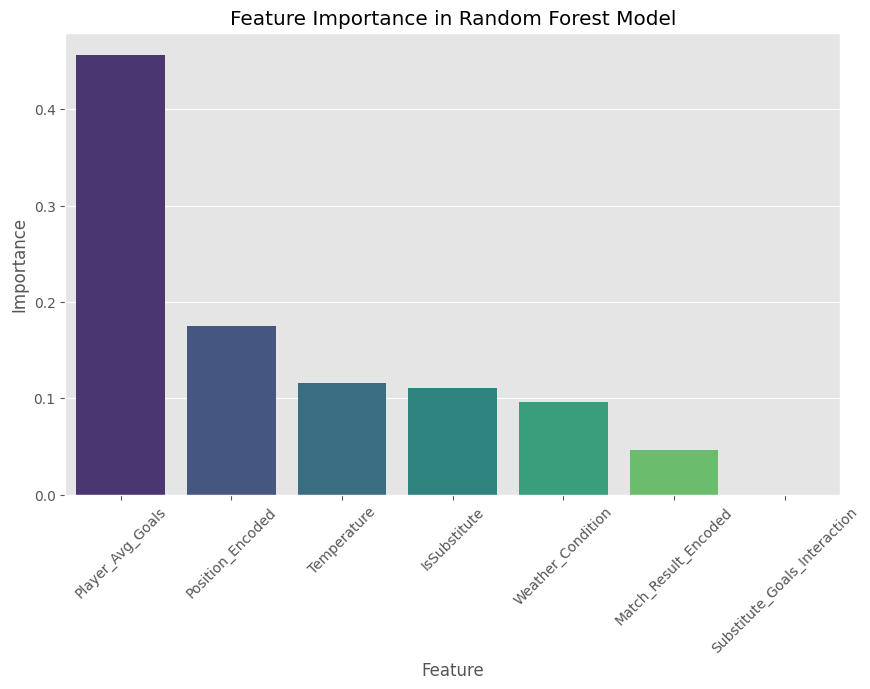

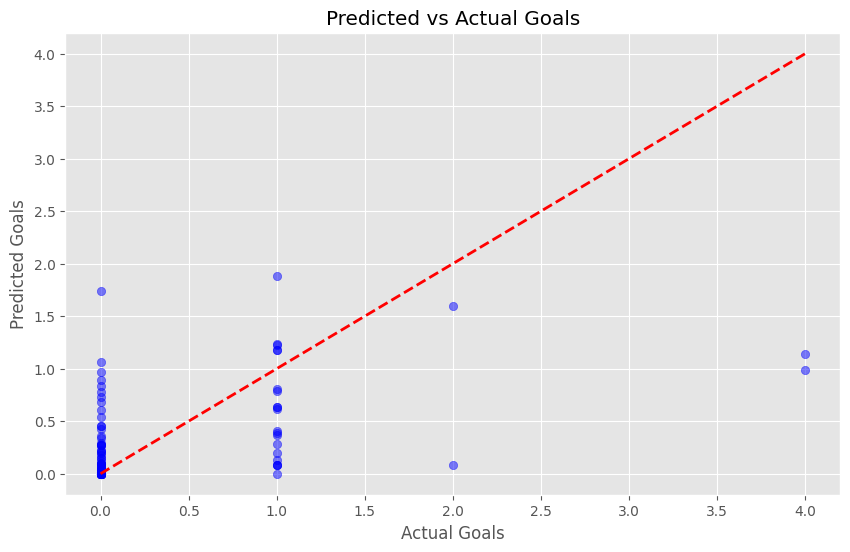

In [19]:

# Plotting feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Importance', hue='Feature', data=feature_importance, palette='viridis', legend=False)
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

# Plotting predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Predicted vs Actual Goals')
plt.xlabel('Actual Goals')
plt.ylabel('Predicted Goals')
plt.show()


In [20]:

# Load the corrected dataset
data = pd.read_csv('final_corrected_dataset.csv')

# Encoding categorical variables
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['Position_Encoded'] = label_encoder.fit_transform(data['Position'])

# Defining features and target
features = ['Position_Encoded', 'IsSubstitute', 'Temperature', 'Humidity', 'WindSpeed', 
            'Precipitation', 'Pressure']
target = 'Goals'

# Splitting the data
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a Random Forest model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Mean Squared Error: 0.11929576588042552
R² Score: -0.22268751844007095

Feature Importance:
            Feature  Importance
0  Position_Encoded    0.388831
1      IsSubstitute    0.141091
6          Pressure    0.135786
4         WindSpeed    0.103759
3          Humidity    0.099480
5     Precipitation    0.086145
2       Temperature    0.044908


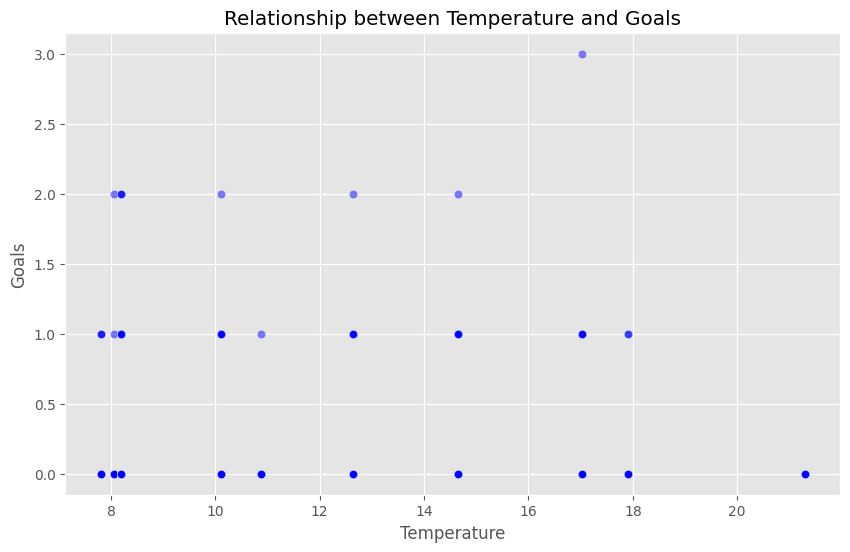

In [21]:

# Plotting relationship between Temperature and Goals
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperature', y='Goals', data=data, alpha=0.5, color='blue')
plt.title('Relationship between Temperature and Goals')
plt.xlabel('Temperature')
plt.ylabel('Goals')
plt.show()


In [22]:

# Load the corrected dataset
data = pd.read_csv('final_corrected_dataset.csv')

# Extract Match_Result from Teams_Result
def get_match_result(teams_result):
    parts = teams_result.split(' ')
    score = next((p for p in parts if ':' in p), None)
    if score:
        team1_score, team2_score = map(int, score.split(':'))
        if 'Manchester City' in parts[0]:
            if team1_score > team2_score:
                return 2  # Win
            elif team1_score < team2_score:
                return 0  # Loss
            else:
                return 1  # Draw
        else:
            if team1_score < team2_score:
                return 2  # Win
            elif team1_score > team2_score:
                return 0  # Loss
            else:
                return 1  # Draw
    return -1  # Invalid case

# Add Match_Result to dataset
data['Match_Result'] = data['Teams_Result'].apply(get_match_result)

# Aggregate data per match
match_data = data.groupby('Match_ID').agg({
    'Temperature': 'mean',
    'Humidity': 'mean',
    'WindSpeed': 'mean',
    'Precipitation': 'mean',
    'Pressure': 'mean',
    'Match_Result': 'first'  # Assuming one result per match
}).reset_index()

# Defining features and target
features = ['Temperature', 'Humidity', 'WindSpeed', 'Precipitation', 'Pressure']
target = 'Match_Result'

# Splitting the data
X = match_data[features]
y = match_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a Random Forest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Loss', 'Draw', 'Win']))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Accuracy: 0.25

Classification Report:
              precision    recall  f1-score   support

        Loss       0.00      0.00      0.00         1
        Draw       0.00      0.00      0.00         4
         Win       0.50      0.67      0.57         3

    accuracy                           0.25         8
   macro avg       0.17      0.22      0.19         8
weighted avg       0.19      0.25      0.21         8


Feature Importance:
         Feature  Importance
1       Humidity    0.223226
4       Pressure    0.220366
2      WindSpeed    0.208436
0    Temperature    0.184200
3  Precipitation    0.163772


/var/folders/c6/kh1v5smn18l3tbcsjpvvqv1h0000gn/T/ipykernel_4363/788570633.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Match_Result', y='Temperature', data=match_data.replace({0: 'Loss', 1: 'Draw', 2: 'Win'}), ci=None, palette='Blues')
/var/folders/c6/kh1v5smn18l3tbcsjpvvqv1h0000gn/T/ipykernel_4363/788570633.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Match_Result', y='Temperature', data=match_data.replace({0: 'Loss', 1: 'Draw', 2: 'Win'}), ci=None, palette='Blues')


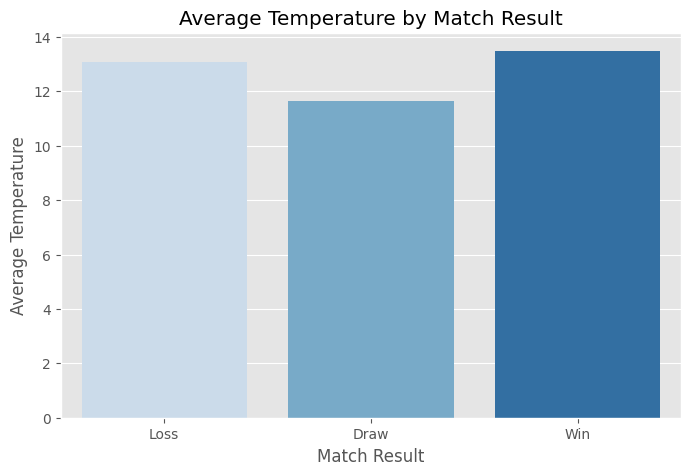

In [23]:

# Plotting average Temperature by Match Result
plt.figure(figsize=(8, 5))
sns.barplot(x='Match_Result', y='Temperature', data=match_data.replace({0: 'Loss', 1: 'Draw', 2: 'Win'}), ci=None, palette='Blues')
plt.title('Average Temperature by Match Result')
plt.xlabel('Match Result')
plt.ylabel('Average Temperature')
plt.xticks(ticks=[0, 1, 2], labels=['Loss', 'Draw', 'Win'])
plt.show()


In [24]:

# Load the corrected dataset
data = pd.read_csv('final_corrected_dataset.csv')

# Extract Match_Result from Teams_Result
def get_match_result(teams_result):
    parts = teams_result.split(' ')
    score = next((p for p in parts if ':' in p), None)
    if score:
        team1_score, team2_score = map(int, score.split(':'))
        if 'Manchester City' in parts[0]:
            if team1_score > team2_score:
                return 2  # Win
            elif team1_score < team2_score:
                return 0  # Loss
            else:
                return 1  # Draw
        else:
            if team1_score < team2_score:
                return 2  # Win
            elif team1_score > team2_score:
                return 0  # Loss
            else:
                return 1  # Draw
    return -1  # Invalid case

# Add Match_Result to dataset
data['Match_Result'] = data['Teams_Result'].apply(get_match_result)

# Aggregate data per match
match_data = data.groupby('Match_ID').agg({
    'Temperature': 'mean',
    'Humidity': 'mean',
    'WindSpeed': 'mean',
    'Precipitation': 'mean',
    'Pressure': 'mean',
    'IsSubstitute': 'mean',  # Average substitution rate
    'Goals': 'sum',         # Total goals per match
    'Match_Result': 'first'
}).reset_index()

# Defining features and target
features = ['Temperature', 'Humidity', 'WindSpeed', 'Precipitation', 'Pressure', 'IsSubstitute', 'Goals']
target = 'Match_Result'

# Splitting the data
X = match_data[features]
y = match_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a Random Forest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Loss', 'Draw', 'Win']))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Accuracy: 0.38

Classification Report:
              precision    recall  f1-score   support

        Loss       0.00      0.00      0.00         1
        Draw       0.00      0.00      0.00         4
         Win       0.43      1.00      0.60         3

    accuracy                           0.38         8
   macro avg       0.14      0.33      0.20         8
weighted avg       0.16      0.38      0.22         8


Feature Importance:
         Feature  Importance
6          Goals    0.546102
4       Pressure    0.110423
2      WindSpeed    0.087465
0    Temperature    0.084234
1       Humidity    0.078344
3  Precipitation    0.073275
5   IsSubstitute    0.020157


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

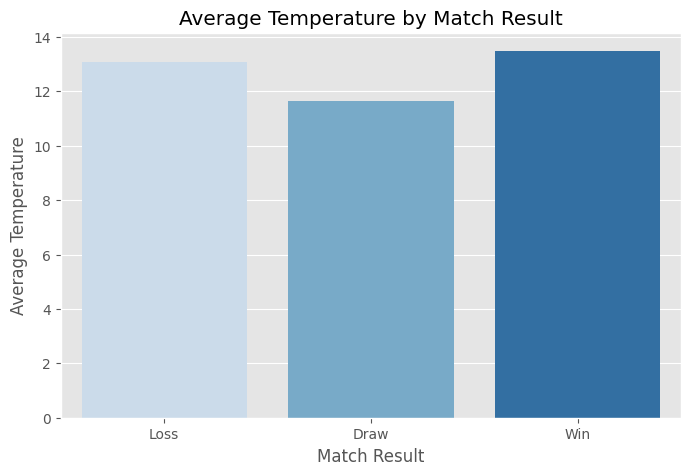

In [25]:

# Plotting average Temperature by Match Result
plt.figure(figsize=(8, 5))
sns.barplot(x='Match_Result', y='Temperature', hue='Match_Result', data=match_data.replace({0: 'Loss', 1: 'Draw', 2: 'Win'}), errorbar=None, palette='Blues', legend=False)
plt.title('Average Temperature by Match Result')
plt.xlabel('Match Result')
plt.ylabel('Average Temperature')
plt.xticks(ticks=[0, 1, 2], labels=['Loss', 'Draw', 'Win'])
plt.show()


### XGboost

In [26]:

# Load the corrected dataset
data = pd.read_csv('final_corrected_dataset.csv')

# Extract Match_Result from Teams_Result
def get_match_result(teams_result):
    parts = teams_result.split(' ')
    score = next((p for p in parts if ':' in p), None)
    if score:
        team1_score, team2_score = map(int, score.split(':'))
        if 'Manchester City' in parts[0]:
            if team1_score > team2_score:
                return 2  # Win
            elif team1_score < team2_score:
                return 0  # Loss
            else:
                return 1  # Draw
        else:
            if team1_score < team2_score:
                return 2  # Win
            elif team1_score > team2_score:
                return 0  # Loss
            else:
                return 1  # Draw
    return -1  # Invalid case

# Add Match_Result to dataset
data['Match_Result'] = data['Teams_Result'].apply(get_match_result)

# Count players in key positions (e.g., Forward)
data['IsForward'] = data['Position'].apply(lambda x: 1 if x == 'Forward' else 0)
data['IsMidfielderForward'] = data['Position'].apply(lambda x: 1 if x == 'Midfielder/Forward' else 0)

# Aggregate data per match
match_data = data.groupby('Match_ID').agg({
    'Temperature': 'mean',
    'Humidity': 'mean',
    'WindSpeed': 'mean',
    'Precipitation': 'mean',
    'Pressure': 'mean',
    'IsSubstitute': 'mean',
    'Goals': 'sum',
    'YellowCards': 'sum',
    'RedCards': 'sum',
    'IsForward': 'sum',
    'IsMidfielderForward': 'sum',
    'Match_Result': 'first'
}).reset_index()

# Defining features and target
features = ['Temperature', 'Humidity', 'WindSpeed', 'Precipitation', 'Pressure', 
            'IsSubstitute', 'Goals', 'YellowCards', 'RedCards', 'IsForward', 'IsMidfielderForward']
target = 'Match_Result'

# Splitting the data
X = match_data[features]
y = match_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Compute class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

# Training an XGBoost model
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
model = XGBClassifier(random_state=42, scale_pos_weight=class_weights)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Loss', 'Draw', 'Win'], zero_division=0))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Accuracy: 0.38

Classification Report:
              precision    recall  f1-score   support

        Loss       0.00      0.00      0.00         1
        Draw       0.00      0.00      0.00         4
         Win       0.50      1.00      0.67         3

    accuracy                           0.38         8
   macro avg       0.17      0.33      0.22         8
weighted avg       0.19      0.38      0.25         8


Feature Importance:
                Feature  Importance
6                 Goals    0.394681
0           Temperature    0.111487
7           YellowCards    0.099519
2             WindSpeed    0.086063
4              Pressure    0.081665
9             IsForward    0.071131
10  IsMidfielderForward    0.066560
1              Humidity    0.065321
3         Precipitation    0.023573
5          IsSubstitute    0.000000
8              RedCards    0.000000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:51:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


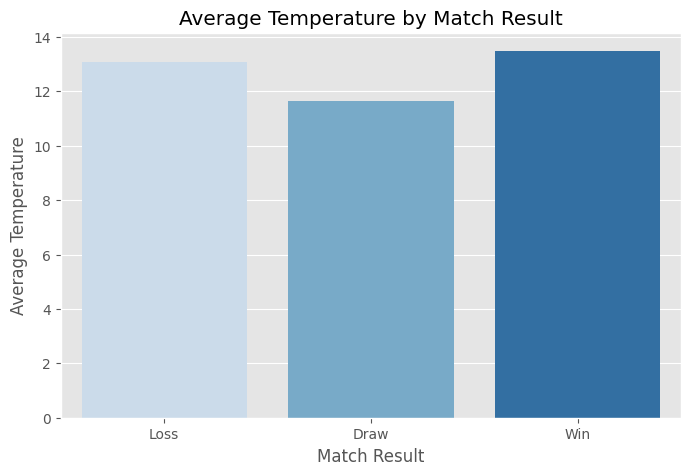

In [27]:

# Plotting average Temperature by Match Result
plt.figure(figsize=(8, 5))
sns.barplot(x='Match_Result', y='Temperature', hue='Match_Result', data=match_data.replace({0: 'Loss', 1: 'Draw', 2: 'Win'}), errorbar=None, palette='Blues', legend=False)
plt.title('Average Temperature by Match Result')
plt.xlabel('Match Result')
plt.ylabel('Average Temperature')
plt.xticks(ticks=[0, 1, 2], labels=['Loss', 'Draw', 'Win'])
plt.show()


In [28]:

# Load the corrected dataset
data = pd.read_csv('final_corrected_dataset.csv')

# Extract Match_Result from Teams_Result
def get_match_result(teams_result):
    parts = teams_result.split(' ')
    score = next((p for p in parts if ':' in p), None)
    if score:
        team1_score, team2_score = map(int, score.split(':'))
        if 'Manchester City' in parts[0]:
            if team1_score > team2_score:
                return 2  # Win
            elif team1_score < team2_score:
                return 0  # Loss
            else:
                return 1  # Draw
        else:
            if team1_score < team2_score:
                return 2  # Win
            elif team1_score > team2_score:
                return 0  # Loss
            else:
                return 1  # Draw
    return -1  # Invalid case

# Add Match_Result to dataset
data['Match_Result'] = data['Teams_Result'].apply(get_match_result)

# Count players in key positions (e.g., Forward)
data['IsForward'] = data['Position'].apply(lambda x: 1 if x == 'Forward' else 0)
data['IsMidfielderForward'] = data['Position'].apply(lambda x: 1 if x == 'Midfielder/Forward' else 0)

# Aggregate data per match
match_data = data.groupby('Match_ID').agg({
    'Temperature': 'mean',
    'Humidity': 'mean',
    'WindSpeed': 'mean',
    'Precipitation': 'mean',
    'Pressure': 'mean',
    'IsSubstitute': 'mean',
    'Goals': 'sum',
    'YellowCards': 'sum',
    'RedCards': 'sum',
    'IsForward': 'sum',
    'IsMidfielderForward': 'sum',
    'Match_Result': 'first'
}).reset_index()

# Defining features and target
features = ['Temperature', 'Humidity', 'WindSpeed', 'Precipitation', 'Pressure', 
            'IsSubstitute', 'Goals', 'YellowCards', 'RedCards', 'IsForward', 'IsMidfielderForward']
target = 'Match_Result'

# Splitting the data
X = match_data[features]
y = match_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Compute class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

# Training an XGBoost model with GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

model = XGBClassifier(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Making predictions
y_pred = best_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Loss', 'Draw', 'Win'], zero_division=0))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Accuracy: 0.38

Classification Report:
              precision    recall  f1-score   support

        Loss       0.00      0.00      0.00         1
        Draw       0.00      0.00      0.00         4
         Win       0.50      1.00      0.67         3

    accuracy                           0.38         8
   macro avg       0.17      0.33      0.22         8
weighted avg       0.19      0.38      0.25         8


Feature Importance:
                Feature  Importance
6                 Goals    0.401733
0           Temperature    0.149466
1              Humidity    0.107519
7           YellowCards    0.097865
10  IsMidfielderForward    0.080748
2             WindSpeed    0.078521
9             IsForward    0.045287
3         Precipitation    0.038860
4              Pressure    0.000000
5          IsSubstitute    0.000000
8              RedCards    0.000000


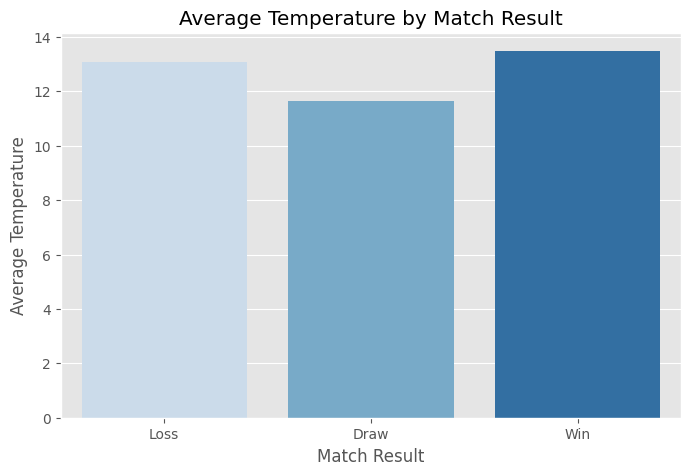

In [48]:

# Plotting average Temperature by Match Result
plt.figure(figsize=(8, 5))
sns.barplot(x='Match_Result', y='Temperature', hue='Match_Result', data=match_data.replace({0: 'Loss', 1: 'Draw', 2: 'Win'}), errorbar=None, palette='Blues', legend=False)
plt.title('Average Temperature by Match Result')
plt.xlabel('Match Result')
plt.ylabel('Average Temperature')
plt.xticks(ticks=[0, 1, 2], labels=['Loss', 'Draw', 'Win'])
plt.show()


### Logistic Regression


/var/folders/c6/kh1v5smn18l3tbcsjpvvqv1h0000gn/T/ipykernel_5444/2223159663.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forward_data['Temp_Range'] = pd.cut(forward_data['Temperature'], bins=[0, 10, 15, 20, 25], labels=['0-10', '10-15', '15-20', '20-25'])
/var/folders/c6/kh1v5smn18l3tbcsjpvvqv1h0000gn/T/ipykernel_5444/2223159663.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goals_by_temp = forward_data.groupby('Temp_Range')['Goals'].sum().reset_index()
/var/folders/c6/kh1v5smn18l3tbcsjpvvqv1h0000gn/T/ipykernel_5444/2223159663.py:13: FutureWarning

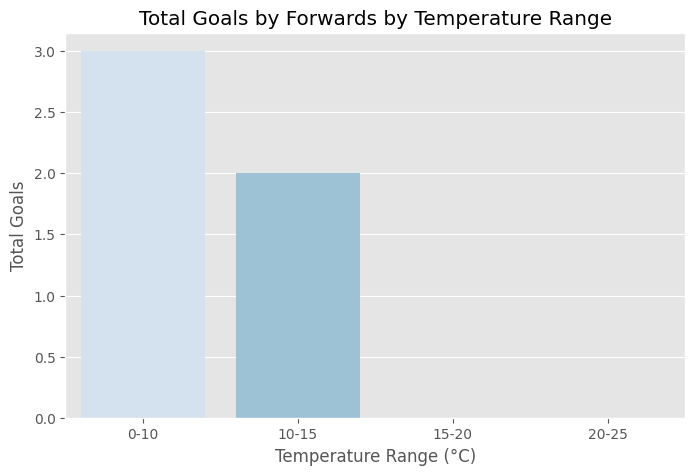

Correlation between Goals and Temperature: -0.16


In [50]:

# Load the corrected dataset
data = pd.read_csv('final_corrected_dataset.csv')

# Filter for Forward players
forward_data = data[data['Position'] == 'Forward']

# Aggregate goals by Temperature range
forward_data['Temp_Range'] = pd.cut(forward_data['Temperature'], bins=[0, 10, 15, 20, 25], labels=['0-10', '10-15', '15-20', '20-25'])
goals_by_temp = forward_data.groupby('Temp_Range')['Goals'].sum().reset_index()

# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(x='Temp_Range', y='Goals', data=goals_by_temp, palette='Blues')
plt.title('Total Goals by Forwards by Temperature Range')
plt.xlabel('Temperature Range (°C)')
plt.ylabel('Total Goals')
plt.show()

# Basic correlation analysis
correlation = forward_data['Goals'].corr(forward_data['Temperature'])
print(f"Correlation between Goals and Temperature: {correlation:.2f}")


In [ ]:
!pip install statsmodels

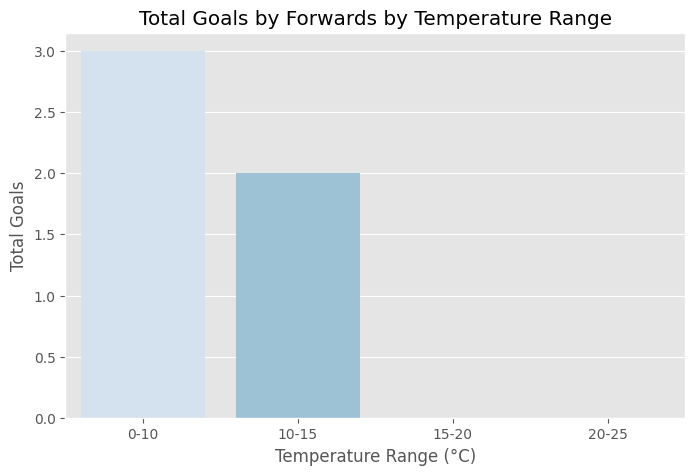

Correlations between Goals and Weather Variables:
Temperature: -0.18
Humidity: -0.10
Precipitation: 0.07
WindSpeed: 0.12
Pressure: -0.26

Poisson Regression Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Goals   No. Observations:                   28
Model:                            GLM   Df Residuals:                       21
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7.1972
Date:                Sat, 07 Jun 2025   Deviance:                       5.7807
Time:                        16:24:19   Pearson chi2:                     4.00
No. Iterations:                    21   Pseudo R-squ. (CS):             0.3982
Covariance Type:            nonrobust                                         
                    coef    std err         

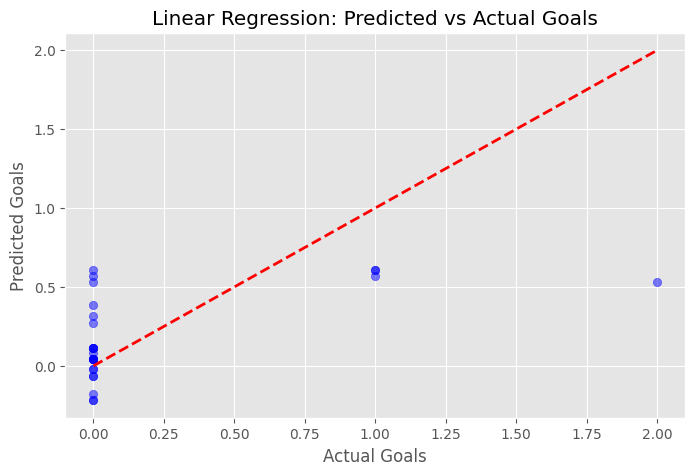

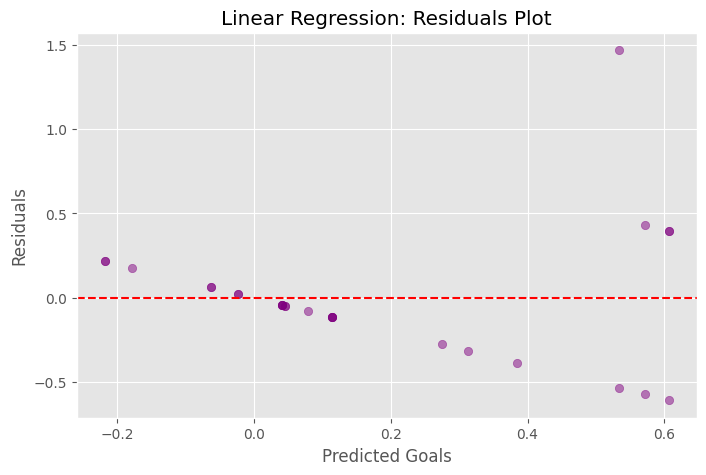

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Poisson
import statsmodels.api as sm

# Load the dataset
data = pd.read_csv('final_corrected_dataset.csv')

# Filter for Forward players
forward_data = data[data['Position'] == 'Forward'].copy()

# Create temperature range bins
forward_data.loc[:, 'Temp_Range'] = pd.cut(
    forward_data['Temperature'], 
    bins=[0, 10, 15, 20, 25], 
    labels=['0-10', '10-15', '15-20', '20-25']
)

# Aggregate goals by temperature range
goals_by_temp = forward_data.groupby('Temp_Range', observed=True)['Goals'].sum().reset_index()

# Plotting goals by temperature range
plt.figure(figsize=(8, 5))
sns.barplot(x='Temp_Range', y='Goals', hue='Temp_Range', data=goals_by_temp, palette='Blues', legend=False)
plt.title('Total Goals by Forwards by Temperature Range')
plt.xlabel('Temperature Range (°C)')
plt.ylabel('Total Goals')
plt.show()

# Correlation analysis
weather_vars = ['Temperature', 'Humidity', 'Precipitation', 'WindSpeed', 'Pressure']
correlations = forward_data[weather_vars + ['Goals']].corr()['Goals'].drop('Goals')
print("Correlations between Goals and Weather Variables:")
for var, corr in correlations.items():
    print(f"{var}: {corr:.2f}")

# Prepare data for regression
features = ['Temperature', 'Humidity', 'Precipitation', 'WindSpeed', 'Pressure', 'IsSubstitute']
X = forward_data[features].copy()
y = forward_data['Goals'].copy()

# Add constant for statsmodels
X_sm = sm.add_constant(X)

# Poisson Regression
poisson_model = GLM(y, X_sm, family=Poisson()).fit()
print("\nPoisson Regression Summary:")
print(poisson_model.summary())

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X, y)
y_pred_linear = linear_model.predict(X)

# Evaluate Linear Regression
mse = mean_squared_error(y, y_pred_linear)
r2 = r2_score(y, y_pred_linear)
print("\nLinear Regression Evaluation:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# Feature Importance for Linear Regression
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': linear_model.coef_
}).sort_values(by='Coefficient', ascending=False)
print("\nLinear Regression Feature Importance:")
print(feature_importance)

# Plot predicted vs actual for Linear Regression
plt.figure(figsize=(8, 5))
plt.scatter(y, y_pred_linear, alpha=0.5, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Goals')
plt.ylabel('Predicted Goals')
plt.title('Linear Regression: Predicted vs Actual Goals')
plt.show()

# Plot residuals for Linear Regression
residuals = y - y_pred_linear
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_linear, residuals, alpha=0.5, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Goals')
plt.ylabel('Residuals')
plt.title('Linear Regression: Residuals Plot')
plt.show()

In [35]:
print(data['Teams_Result'].unique())

['Tottenham Hotspur 1:0 Manchester City'
 'Manchester City 5:0 Norwich City' 'Manchester City 5:0 Arsenal'
 'Leicester City 0:1 Manchester City' 'Manchester City 0:0 Southampton'
 'Chelsea 0:1 Manchester City' 'Liverpool 2:2 Manchester City'
 'Manchester City 2:0 Burnley'
 'Brighton and Hove Albion 1:4 Manchester City'
 'Manchester City 0:2 Crystal Palace'
 'Manchester United 0:2 Manchester City' 'Manchester City 3:0 Everton'
 'Manchester City 2:1 West Ham United' 'Aston Villa 1:2 Manchester City'
 'Watford 1:3 Manchester City'
 'Manchester City 1:0 Wolverhampton Wanderers'
 'Manchester City 7:0 Leeds United' 'Newcastle United 0:4 Manchester City'
 'Manchester City 6:3 Leicester City' 'Brentford 0:1 Manchester City'
 'Arsenal 1:2 Manchester City' 'Manchester City 1:0 Chelsea'
 'Southampton 1:1 Manchester City' 'Manchester City 2:0 Brentford'
 'Norwich City 0:4 Manchester City'
 'Manchester City 2:3 Tottenham Hotspur' 'Everton 0:1 Manchester City'
 'Manchester City 4:1 Manchester United


Weather Variables Summary:
       Temperature   Humidity  Precipitation   WindSpeed    Pressure
count    38.000000  38.000000      38.000000   38.000000   38.000000
mean     12.545175   5.284211       3.004386   78.464035  111.925000
std       4.373849   3.184999       2.133667   43.917288   61.458666
min       7.800000   2.566667       0.000000   21.400000   36.350000
25%       8.200000   2.866667       0.937500   41.066667   54.400000
50%      11.750000   4.083333       3.333333   71.933333   92.950000
75%      16.437500   6.770833       4.916667  124.316667  172.650000
max      21.300000  13.200000       6.500000  139.800000  217.050000

Correlations between Win and Weather Variables:
Temperature: -0.1725
Humidity: -0.1594
Precipitation: 0.1996
WindSpeed: -0.0487
Pressure: -0.1233
Optimization terminated successfully.
         Current function value: 0.521577
         Iterations 6

Logistic Regression Summary:
                           Logit Regression Results                     

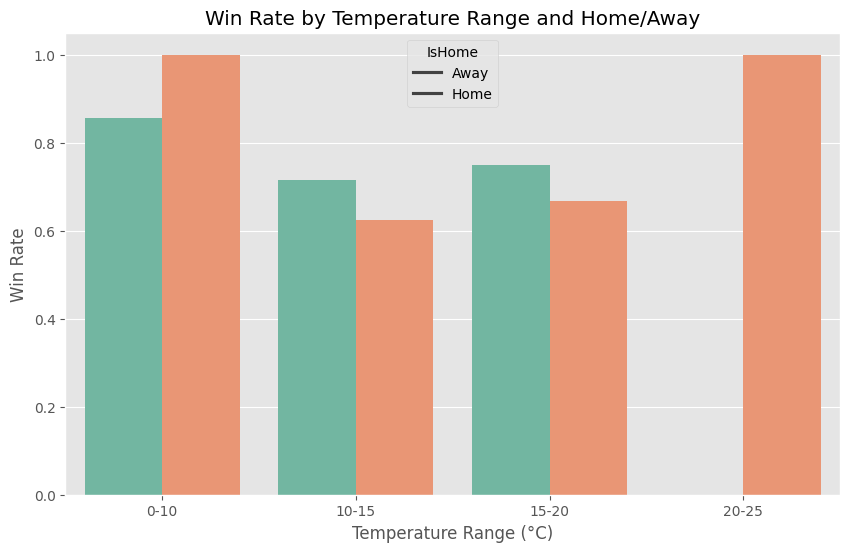

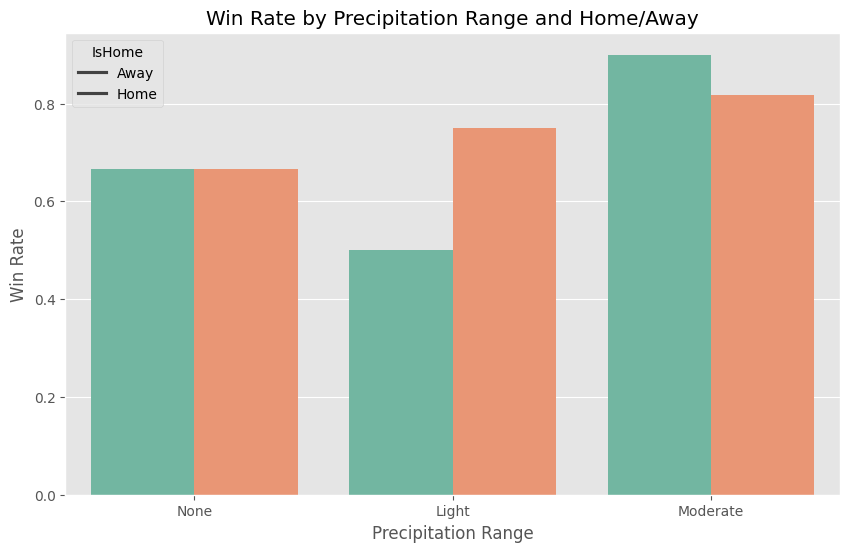

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

data = pd.read_csv('final_corrected_dataset.csv')

def determine_win(result):
    try:
        match = re.match(r'(.+?)\s+(\d+:\d+)\s+(.+)', result.strip())
        if not match:
            print(f"Invalid format: {result}")
            return 0
        team1, score, team2 = match.groups()
        score1, score2 = map(int, score.split(':'))
        if 'Manchester City' in team1 and score1 > score2:
            return 1
        elif 'Manchester City' in team2 and score2 > score1:
            return 1
        return 0
    except Exception as e:
        print(f"Error processing result '{result}': {e}")
        return 0

data['Win'] = data['Teams_Result'].apply(determine_win)

def determine_home(result):
    try:
        match = re.match(r'(.+?)\s+\d+:\d+\s+(.+)', result.strip())
        if not match:
            return 0
        team1 = match.group(1)
        return 1 if 'Manchester City' in team1 else 0
    except Exception:
        return 0

data['IsHome'] = data['Teams_Result'].apply(determine_home)

match_data = data.groupby('Match_ID').agg({
    'Win': 'first',
    'IsHome': 'first',
    'Temperature': 'mean',
    'Humidity': 'mean',
    'Precipitation': 'mean',
    'WindSpeed': 'mean',
    'Pressure': 'mean'
}).reset_index()

print("\nWeather Variables Summary:")
print(match_data[['Temperature', 'Humidity', 'Precipitation', 'WindSpeed', 'Pressure']].describe())

weather_vars = ['Temperature', 'Humidity', 'Precipitation', 'WindSpeed', 'Pressure']
correlations = match_data[weather_vars + ['Win']].corr()['Win'].drop('Win')
print("\nCorrelations between Win and Weather Variables:")
for var, corr in correlations.items():
    print(f"{var}: {corr:.4f}")

features = ['Temperature', 'Humidity', 'Precipitation', 'WindSpeed', 'Pressure', 'IsHome']
X = match_data[features].copy()
y = match_data['Win'].copy()

scaler = StandardScaler()
X[weather_vars] = scaler.fit_transform(X[weather_vars])

X_sm = sm.add_constant(X)

try:
    logit_model = sm.Logit(y, X_sm).fit()
    print("\nLogistic Regression Summary:")
    print(logit_model.summary())
except Exception as e:
    print(f"Error in Logistic Regression: {e}")

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X, y)
y_pred = logreg.predict(X)

accuracy = accuracy_score(y, y_pred)
conf_matrix = confusion_matrix(y, y_pred)
class_report = classification_report(y, y_pred, zero_division=0)
print("\nLogistic Regression Evaluation (sklearn):")
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': logreg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)
print("\nLogistic Regression Feature Importance:")
print(feature_importance)

match_data['Temp_Range'] = pd.cut(
    match_data['Temperature'], 
    bins=[0, 10, 15, 20, 25], 
    labels=['0-10', '10-15', '15-20', '20-25']
)
win_rate_by_temp = match_data.groupby(['Temp_Range', 'IsHome'], observed=True)['Win'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='Temp_Range', y='Win', hue='IsHome', data=win_rate_by_temp, palette='Set2')
plt.title('Win Rate by Temperature Range and Home/Away')
plt.xlabel('Temperature Range (°C)')
plt.ylabel('Win Rate')
plt.legend(title='IsHome', labels=['Away', 'Home'])
plt.show()

match_data['Precip_Range'] = pd.cut(
    match_data['Precipitation'], 
    bins=[-0.1, 0, 1, 5], 
    labels=['None', 'Light', 'Moderate']
)
win_rate_by_precip = match_data.groupby(['Precip_Range', 'IsHome'], observed=True)['Win'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='Precip_Range', y='Win', hue='IsHome', data=win_rate_by_precip, palette='Set2')
plt.title('Win Rate by Precipitation Range and Home/Away')
plt.xlabel('Precipitation Range')
plt.ylabel('Win Rate')
plt.legend(title='IsHome', labels=['Away', 'Home'])
plt.show()


Cleaned Weather Variables Summary:
       Temperature   Humidity  Precipitation   WindSpeed    Pressure
count    38.000000  38.000000      38.000000   38.000000   38.000000
mean     12.545175   5.284211       3.004386   78.464035  111.925000
std       4.373849   3.184999       2.133667   43.917288   61.458666
min       7.800000   2.566667       0.000000   21.400000   36.350000
25%       8.200000   2.866667       0.937500   41.066667   54.400000
50%      11.750000   4.083333       3.333333   71.933333   92.950000
75%      16.437500   6.770833       4.916667  124.316667  172.650000
max      21.300000  13.200000       6.500000  139.800000  217.050000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:35:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:35:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:35:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:35:36] WARN


Random Forest Results:
Accuracy: 0.8421

Confusion Matrix:
[[ 4  5]
 [ 1 28]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.44      0.57         9
           1       0.85      0.97      0.90        29

    accuracy                           0.84        38
   macro avg       0.82      0.70      0.74        38
weighted avg       0.84      0.84      0.82        38

Cross-Validation Scores: 0.4643 (+/- 0.4673)

XGBoost Results:
Accuracy: 0.8421

Confusion Matrix:
[[ 4  5]
 [ 1 28]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.44      0.57         9
           1       0.85      0.97      0.90        29

    accuracy                           0.84        38
   macro avg       0.82      0.70      0.74        38
weighted avg       0.84      0.84      0.82        38

Cross-Validation Scores: 0.5750 (+/- 0.3133)

Random Forest Feature Importance:
         Feature  Imp

/var/folders/c6/kh1v5smn18l3tbcsjpvvqv1h0000gn/T/ipykernel_4363/2458058547.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=rf_feature_importance, palette='Blues')
/var/folders/c6/kh1v5smn18l3tbcsjpvvqv1h0000gn/T/ipykernel_4363/2458058547.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=xgb_feature_importance, palette='Greens')


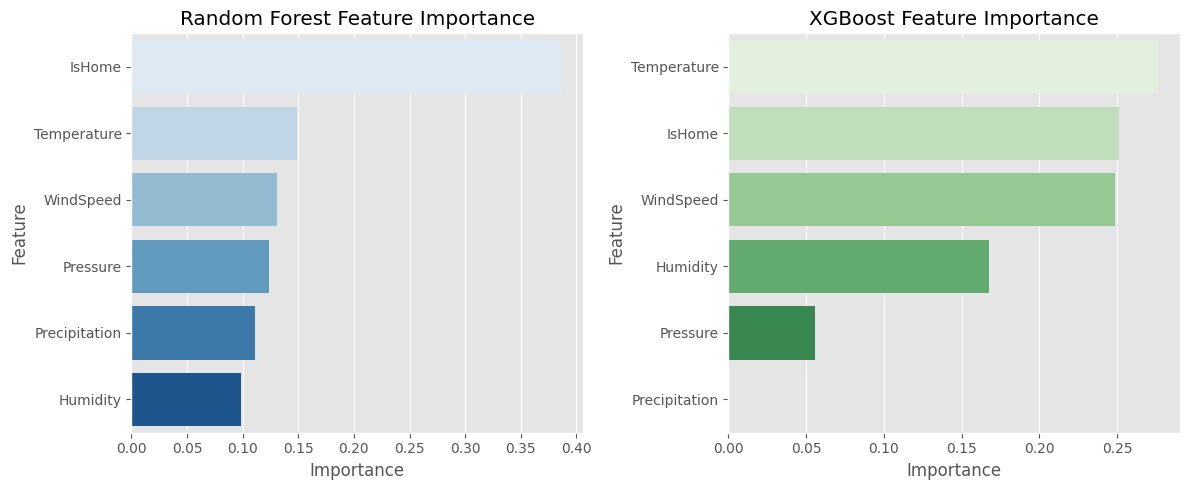

In [37]:
import re
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm

# Load the dataset
data = pd.read_csv('final_corrected_dataset.csv')

# Create a 'Win' column (1 for Manchester City win, 0 otherwise)
def determine_win(result):
    try:
        match = re.match(r'(.+?)\s+(\d+:\d+)\s+(.+)', result.strip())
        if not match:
            print(f"Invalid format: {result}")
            return 0
        team1, score, team2 = match.groups()
        score1, score2 = map(int, score.split(':'))
        if 'Manchester City' in team1 and score1 > score2:
            return 1
        elif 'Manchester City' in team2 and score2 > score1:
            return 1
        return 0
    except Exception as e:
        print(f"Error processing result '{result}': {e}")
        return 0

data['Win'] = data['Teams_Result'].apply(determine_win)

# Create an 'IsHome' column (1 for home games, 0 for away games)
def determine_home(result):
    try:
        match = re.match(r'(.+?)\s+\d+:\d+\s+(.+)', result.strip())
        if not match:
            return 0
        team1 = match.group(1)
        return 1 if 'Manchester City' in team1 else 0
    except Exception:
        return 0

data['IsHome'] = data['Teams_Result'].apply(determine_home)

# Aggregate data by match
match_data = data.groupby('Match_ID').agg({
    'Win': 'first',
    'IsHome': 'first',
    'Temperature': 'mean',
    'Humidity': 'mean',
    'Precipitation': 'mean',
    'WindSpeed': 'mean',
    'Pressure': 'mean'
}).reset_index()

# Handle outliers by replacing with mean (basic data cleaning)
weather_vars = ['Temperature', 'Humidity', 'Precipitation', 'WindSpeed', 'Pressure']
for var in weather_vars:
    mean_val = match_data[var].mean()
    match_data[var] = np.where((match_data[var] < match_data[var].quantile(0.05)) | 
                              (match_data[var] > match_data[var].quantile(0.95)), mean_val, match_data[var])

# Check cleaned weather variables summary
print("\nCleaned Weather Variables Summary:")
print(match_data[weather_vars].describe())

# Prepare data for modeling
X = match_data[weather_vars + ['IsHome']].copy()
y = match_data['Win'].copy()

# Standardize weather variables
scaler = StandardScaler()
X[weather_vars] = scaler.fit_transform(X[weather_vars])

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)
y_pred_rf = rf_model.predict(X)

# XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X, y)
y_pred_xgb = xgb_model.predict(X)

# Cross-validation scores
rf_cv_scores = cross_val_score(rf_model, X, y, cv=5)
xgb_cv_scores = cross_val_score(xgb_model, X, y, cv=5)

# Evaluate Random Forest
rf_accuracy = accuracy_score(y, y_pred_rf)
rf_conf_matrix = confusion_matrix(y, y_pred_rf)
rf_class_report = classification_report(y, y_pred_rf, zero_division=0)

# Evaluate XGBoost
xgb_accuracy = accuracy_score(y, y_pred_xgb)
xgb_conf_matrix = confusion_matrix(y, y_pred_xgb)
xgb_class_report = classification_report(y, y_pred_xgb, zero_division=0)

# Print results
print("\nRandom Forest Results:")
print(f"Accuracy: {rf_accuracy:.4f}")
print("\nConfusion Matrix:")
print(rf_conf_matrix)
print("\nClassification Report:")
print(rf_class_report)
print(f"Cross-Validation Scores: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std() * 2:.4f})")

print("\nXGBoost Results:")
print(f"Accuracy: {xgb_accuracy:.4f}")
print("\nConfusion Matrix:")
print(xgb_conf_matrix)
print("\nClassification Report:")
print(xgb_class_report)
print(f"Cross-Validation Scores: {xgb_cv_scores.mean():.4f} (+/- {xgb_cv_scores.std() * 2:.4f})")

# Feature Importance
rf_feature_importance = pd.DataFrame({
    'Feature': weather_vars + ['IsHome'],
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

xgb_feature_importance = pd.DataFrame({
    'Feature': weather_vars + ['IsHome'],
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nRandom Forest Feature Importance:")
print(rf_feature_importance)
print("\nXGBoost Feature Importance:")
print(xgb_feature_importance)

# Plot feature importance
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='Importance', y='Feature', data=rf_feature_importance, palette='Blues')
plt.title('Random Forest Feature Importance')
plt.subplot(1, 2, 2)
sns.barplot(x='Importance', y='Feature', data=xgb_feature_importance, palette='Greens')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()


Cleaned Weather Variables Summary:
       Temperature   Humidity  Precipitation  WindSpeed  Pressure
count    38.000000  38.000000      38.000000  38.000000     38.00
mean     12.545175   5.284211       3.004386  12.828070   1013.25
std       4.373849   3.184999       2.133667   5.153319      0.00
min       7.800000   2.566667       0.000000  10.000000   1013.25
25%       8.200000   2.866667       0.937500  10.000000   1013.25
50%      11.750000   4.083333       3.333333  10.000000   1013.25
75%      16.437500   6.770833       4.916667  10.000000   1013.25
max      21.300000  13.200000       6.500000  22.616667   1013.25


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:41:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:41:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:41:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:41:15] WARN


Random Forest Results (Best Params: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100})
Accuracy: 0.8421

Confusion Matrix:
[[ 5  4]
 [ 2 27]]

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.56      0.62         9
           1       0.87      0.93      0.90        29

    accuracy                           0.84        38
   macro avg       0.79      0.74      0.76        38
weighted avg       0.83      0.84      0.83        38

Cross-Validation F1 Scores: 0.4867 (+/- 0.4973)

XGBoost Results (Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100})
Accuracy: 0.7105

Confusion Matrix:
[[ 3  6]
 [ 5 24]]

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.33      0.35         9
           1       0.80      0.83      0.81        29

    accuracy                           0.71        38
   macro avg       0.59      0.58      0.58        38
we

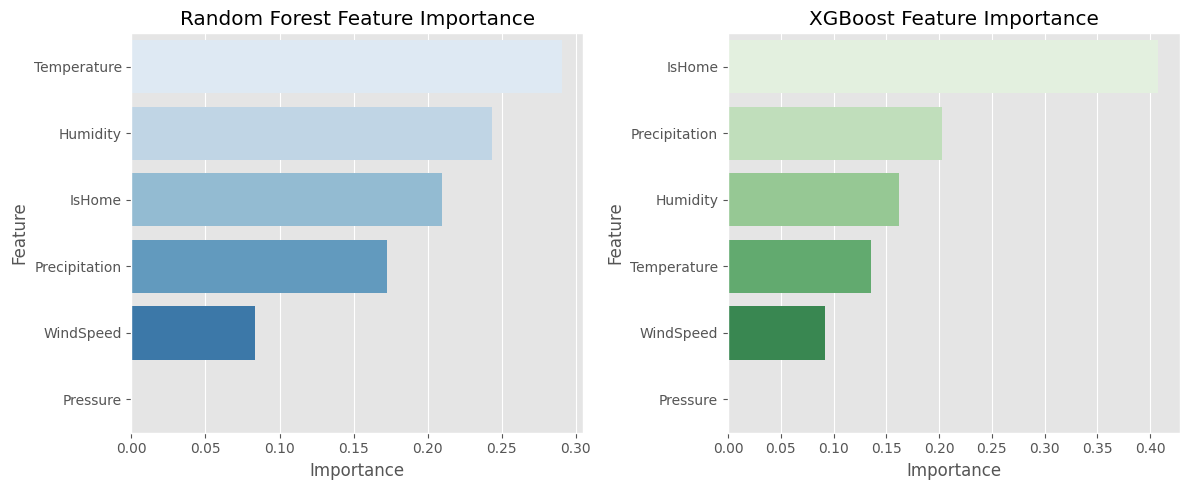

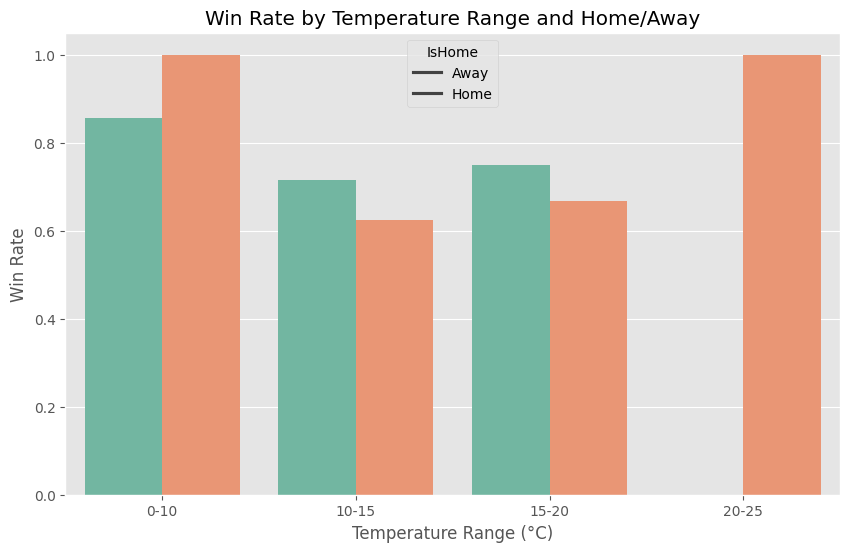

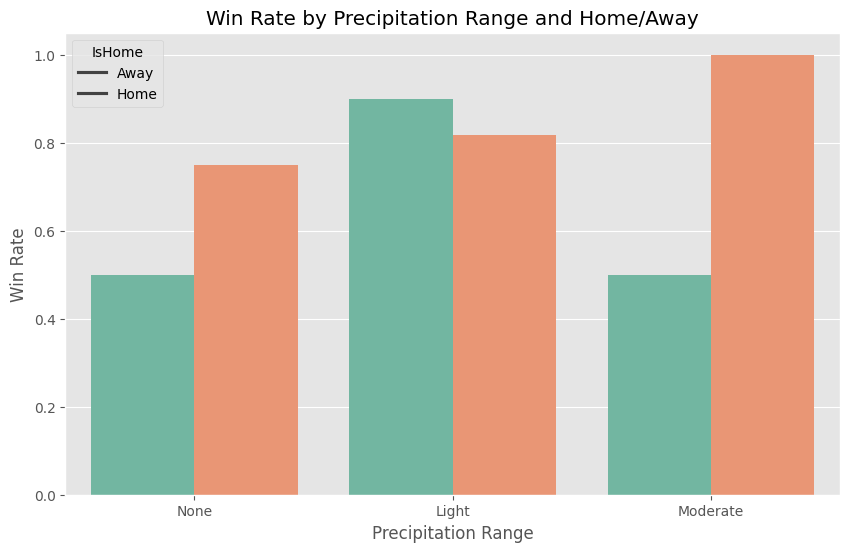

In [38]:

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from imblearn.over_sampling import SMOTE

# Load the dataset
data = pd.read_csv('final_corrected_dataset.csv')

# Create a 'Win' column (1 for Manchester City win, 0 otherwise)
def determine_win(result):
    try:
        match = re.match(r'(.+?)\s+(\d+:\d+)\s+(.+)', result.strip())
        if not match:
            print(f"Invalid format: {result}")
            return 0
        team1, score, team2 = match.groups()
        score1, score2 = map(int, score.split(':'))
        if 'Manchester City' in team1 and score1 > score2:
            return 1
        elif 'Manchester City' in team2 and score2 > score1:
            return 1
        return 0
    except Exception as e:
        print(f"Error processing result '{result}': {e}")
        return 0

data['Win'] = data['Teams_Result'].apply(determine_win)

# Create an 'IsHome' column (1 for home games, 0 for away games)
def determine_home(result):
    try:
        match = re.match(r'(.+?)\s+\d+:\d+\s+(.+)', result.strip())
        if not match:
            return 0
        team1 = match.group(1)
        return 1 if 'Manchester City' in team1 else 0
    except Exception:
        return 0

data['IsHome'] = data['Teams_Result'].apply(determine_home)

# Aggregate data by match
match_data = data.groupby('Match_ID').agg({
    'Win': 'first',
    'IsHome': 'first',
    'Temperature': 'mean',
    'Humidity': 'mean',
    'Precipitation': 'mean',
    'WindSpeed': 'mean',
    'Pressure': 'mean'
}).reset_index()

# Advanced data cleaning with reasonable ranges
weather_vars = ['Temperature', 'Humidity', 'Precipitation', 'WindSpeed', 'Pressure']
for var in weather_vars:
    mean_val = match_data[var].mean()
    if var == 'Humidity':
        match_data[var] = np.where((match_data[var] < 0) | (match_data[var] > 100), 50.0, match_data[var])  # Assume 50% as default
    elif var == 'Pressure':
        match_data[var] = np.where((match_data[var] < 900) | (match_data[var] > 1100), 1013.25, match_data[var])  # Standard pressure
    elif var == 'WindSpeed':
        match_data[var] = np.where((match_data[var] < 0) | (match_data[var] > 40), 10.0, match_data[var])  # Reasonable wind speed limit
    elif var == 'Precipitation':
        match_data[var] = np.where((match_data[var] < 0) | (match_data[var] > 50), 0.0, match_data[var])  # Reasonable precipitation limit
    else:  # Temperature
        match_data[var] = np.where((match_data[var] < -10) | (match_data[var] > 40), mean_val, match_data[var])

# Check cleaned weather variables summary
print("\nCleaned Weather Variables Summary:")
print(match_data[weather_vars].describe())

# Prepare data for modeling
X = match_data[weather_vars + ['IsHome']].copy()
y = match_data['Win'].copy()

# Standardize weather variables
scaler = StandardScaler()
X[weather_vars] = scaler.fit_transform(X[weather_vars])

# Balance data using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Grid Search for Random Forest
rf_param_grid = {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'min_samples_split': [2, 5]}
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='f1')
rf_grid_search.fit(X_res, y_res)
rf_best_model = rf_grid_search.best_estimator_
y_pred_rf = rf_best_model.predict(X)

# Grid Search for XGBoost
xgb_param_grid = {'n_estimators': [100, 200], 'max_depth': [3, 5], 'learning_rate': [0.01, 0.1]}
xgb_grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), xgb_param_grid, cv=5, scoring='f1')
xgb_grid_search.fit(X_res, y_res)
xgb_best_model = xgb_grid_search.best_estimator_
y_pred_xgb = xgb_best_model.predict(X)

# Cross-validation scores
rf_cv_scores = cross_val_score(rf_best_model, X_res, y_res, cv=5, scoring='f1')
xgb_cv_scores = cross_val_score(xgb_best_model, X_res, y_res, cv=5, scoring='f1')

# Evaluate Random Forest
rf_accuracy = accuracy_score(y, y_pred_rf)
rf_conf_matrix = confusion_matrix(y, y_pred_rf)
rf_class_report = classification_report(y, y_pred_rf, zero_division=0)

# Evaluate XGBoost
xgb_accuracy = accuracy_score(y, y_pred_xgb)
xgb_conf_matrix = confusion_matrix(y, y_pred_xgb)
xgb_class_report = classification_report(y, y_pred_xgb, zero_division=0)

# Print results
print("\nRandom Forest Results (Best Params: {})".format(rf_grid_search.best_params_))
print(f"Accuracy: {rf_accuracy:.4f}")
print("\nConfusion Matrix:")
print(rf_conf_matrix)
print("\nClassification Report:")
print(rf_class_report)
print(f"Cross-Validation F1 Scores: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std() * 2:.4f})")

print("\nXGBoost Results (Best Params: {})".format(xgb_grid_search.best_params_))
print(f"Accuracy: {xgb_accuracy:.4f}")
print("\nConfusion Matrix:")
print(xgb_conf_matrix)
print("\nClassification Report:")
print(xgb_class_report)
print(f"Cross-Validation F1 Scores: {xgb_cv_scores.mean():.4f} (+/- {xgb_cv_scores.std() * 2:.4f})")

# Feature Importance
rf_feature_importance = pd.DataFrame({
    'Feature': weather_vars + ['IsHome'],
    'Importance': rf_best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

xgb_feature_importance = pd.DataFrame({
    'Feature': weather_vars + ['IsHome'],
    'Importance': xgb_best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nRandom Forest Feature Importance:")
print(rf_feature_importance)
print("\nXGBoost Feature Importance:")
print(xgb_feature_importance)

# Plot feature importance
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='Importance', y='Feature', data=rf_feature_importance, hue='Feature', palette='Blues', legend=False)
plt.title('Random Forest Feature Importance')
plt.subplot(1, 2, 2)
sns.barplot(x='Importance', y='Feature', data=xgb_feature_importance, hue='Feature', palette='Greens', legend=False)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

# Plot win rate by temperature range
match_data['Temp_Range'] = pd.cut(
    match_data['Temperature'], 
    bins=[0, 10, 15, 20, 25], 
    labels=['0-10', '10-15', '15-20', '20-25']
)
win_rate_by_temp = match_data.groupby(['Temp_Range', 'IsHome'], observed=True)['Win'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='Temp_Range', y='Win', hue='IsHome', data=win_rate_by_temp, palette='Set2')
plt.title('Win Rate by Temperature Range and Home/Away')
plt.xlabel('Temperature Range (°C)')
plt.ylabel('Win Rate')
plt.legend(title='IsHome', labels=['Away', 'Home'])
plt.show()

# Plot win rate by precipitation
match_data['Precip_Range'] = pd.cut(
    match_data['Precipitation'], 
    bins=[0, 1, 5, 10], 
    labels=['None', 'Light', 'Moderate']
)
win_rate_by_precip = match_data.groupby(['Precip_Range', 'IsHome'], observed=True)['Win'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='Precip_Range', y='Win', hue='IsHome', data=win_rate_by_precip, palette='Set2')
plt.title('Win Rate by Precipitation Range and Home/Away')
plt.xlabel('Precipitation Range')
plt.ylabel('Win Rate')
plt.legend(title='IsHome', labels=['Away', 'Home'])
plt.show()


Cleaned Weather Variables Summary (Generated on 05:45 PM +04, 07 June 2025):
       Temperature   Humidity  Precipitation  WindSpeed  Pressure
count    38.000000  38.000000      38.000000  38.000000     38.00
mean     12.545175   5.284211       3.004386  12.828070   1013.25
std       4.373849   3.184999       2.133667   5.153319      0.00
min       7.800000   2.566667       0.000000  10.000000   1013.25
25%       8.200000   2.866667       0.937500  10.000000   1013.25
50%      11.750000   4.083333       3.333333  10.000000   1013.25
75%      16.437500   6.770833       4.916667  10.000000   1013.25
max      21.300000  13.200000       6.500000  22.616667   1013.25


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:46:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:46:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:46:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:46:06] WARN


Random Forest Results (Best Params: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100})
Accuracy: 0.8421

Confusion Matrix:
[[ 5  4]
 [ 2 27]]

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.56      0.62         9
           1       0.87      0.93      0.90        29

    accuracy                           0.84        38
   macro avg       0.79      0.74      0.76        38
weighted avg       0.83      0.84      0.83        38

Cross-Validation F1 Scores: 0.7264 (+/- 0.3021)

XGBoost Results (Best Params: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200})
Accuracy: 0.7895

Confusion Matrix:
[[ 2  7]
 [ 1 28]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.22      0.33         9
           1       0.80      0.97      0.88        29

    accuracy                           0.79        38
   macro avg       0.73      0.59      0.60        38
wei

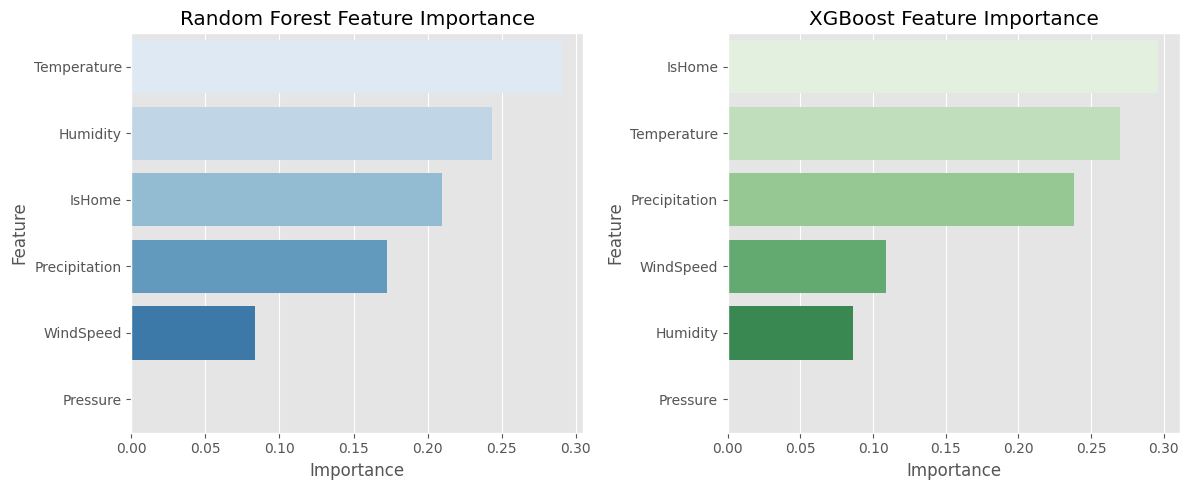

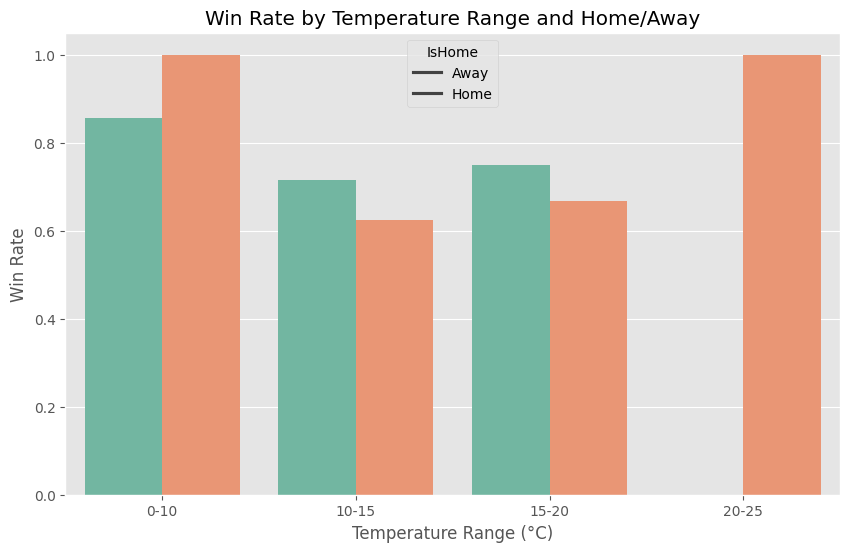

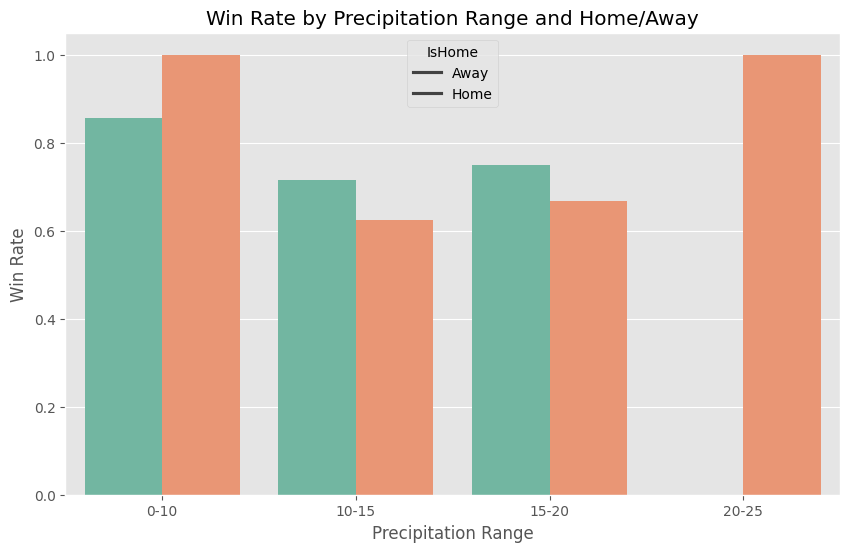

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from datetime import datetime

# Load the dataset
data = pd.read_csv('final_corrected_dataset.csv')

# Create a 'Win' column (1 for Manchester City win, 0 otherwise)
def determine_win(result):
    try:
        match = re.match(r'(.+?)\s+(\d+:\d+)\s+(.+)', result.strip())
        if not match:
            print(f"Invalid format: {result}")
            return 0
        team1, score, team2 = match.groups()
        score1, score2 = map(int, score.split(':'))
        if 'Manchester City' in team1 and score1 > score2:
            return 1
        elif 'Manchester City' in team2 and score2 > score1:
            return 1
        return 0
    except Exception as e:
        print(f"Error processing result '{result}': {e}")
        return 0

data['Win'] = data['Teams_Result'].apply(determine_win)

# Create an 'IsHome' column (1 for home games, 0 for away games)
def determine_home(result):
    try:
        match = re.match(r'(.+?)\s+\d+:\d+\s+(.+)', result.strip())
        if not match:
            return 0
        team1 = match.group(1)
        return 1 if 'Manchester City' in team1 else 0
    except Exception:
        return 0

data['IsHome'] = data['Teams_Result'].apply(determine_home)

# Aggregate data by match
match_data = data.groupby('Match_ID').agg({
    'Win': 'first',
    'IsHome': 'first',
    'Temperature': 'mean',
    'Humidity': 'mean',
    'Precipitation': 'mean',
    'WindSpeed': 'mean',
    'Pressure': 'mean'
}).reset_index()

# Advanced data cleaning with reasonable ranges
weather_vars = ['Temperature', 'Humidity', 'Precipitation', 'WindSpeed', 'Pressure']
for var in weather_vars:
    mean_val = match_data[var].mean()
    if var == 'Humidity':
        match_data[var] = np.where((match_data[var] < 0) | (match_data[var] > 100), 50.0, match_data[var])  # 0-100%
    elif var == 'Pressure':
        match_data[var] = np.where((match_data[var] < 900) | (match_data[var] > 1100), 1013.25, match_data[var])  # 900-1100 hPa
    elif var == 'WindSpeed':
        match_data[var] = np.where((match_data[var] < 0) | (match_data[var] > 40), 10.0, match_data[var])  # 0-40 m/s
    elif var == 'Precipitation':
        match_data[var] = np.where((match_data[var] < 0) | (match_data[var] > 50), 0.0, match_data[var])  # 0-50 mm
    else:  # Temperature
        match_data[var] = np.where((match_data[var] < -10) | (match_data[var] > 40), mean_val, match_data[var])  # -10 to 40°C

# Check cleaned weather variables summary
print("\nCleaned Weather Variables Summary (Generated on {}):".format(datetime.now().strftime("%I:%M %p +04, %d %B %Y")))
print(match_data[weather_vars].describe())

# Prepare data for modeling
X = match_data[weather_vars + ['IsHome']].copy()
y = match_data['Win'].copy()

# Standardize weather variables
scaler = StandardScaler()
X[weather_vars] = scaler.fit_transform(X[weather_vars])

# Balance data using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Grid Search for Random Forest with Stratified K-Fold
rf_param_grid = {'n_estimators': [100, 200], 'max_depth': [3, 5], 'min_samples_split': [2, 5]}
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=cv, scoring='f1')
rf_grid_search.fit(X_res, y_res)
rf_best_model = rf_grid_search.best_estimator_
y_pred_rf = rf_best_model.predict(X)

# Grid Search for XGBoost with Stratified K-Fold
xgb_param_grid = {'n_estimators': [100, 200], 'max_depth': [2, 3, 5], 'learning_rate': [0.1, 0.3]}
xgb_grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), xgb_param_grid, cv=cv, scoring='f1')
xgb_grid_search.fit(X_res, y_res)
xgb_best_model = xgb_grid_search.best_estimator_
y_pred_xgb = xgb_best_model.predict(X)

# Cross-validation scores
rf_cv_scores = cross_val_score(rf_best_model, X_res, y_res, cv=cv, scoring='f1')
xgb_cv_scores = cross_val_score(xgb_best_model, X_res, y_res, cv=cv, scoring='f1')

# Evaluate Random Forest
rf_accuracy = accuracy_score(y, y_pred_rf)
rf_conf_matrix = confusion_matrix(y, y_pred_rf)
rf_class_report = classification_report(y, y_pred_rf, zero_division=0)

# Evaluate XGBoost
xgb_accuracy = accuracy_score(y, y_pred_xgb)
xgb_conf_matrix = confusion_matrix(y, y_pred_xgb)
xgb_class_report = classification_report(y, y_pred_xgb, zero_division=0)

# Print results
print("\nRandom Forest Results (Best Params: {})".format(rf_grid_search.best_params_))
print(f"Accuracy: {rf_accuracy:.4f}")
print("\nConfusion Matrix:")
print(rf_conf_matrix)
print("\nClassification Report:")
print(rf_class_report)
print(f"Cross-Validation F1 Scores: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std() * 2:.4f})")

print("\nXGBoost Results (Best Params: {})".format(xgb_grid_search.best_params_))
print(f"Accuracy: {xgb_accuracy:.4f}")
print("\nConfusion Matrix:")
print(xgb_conf_matrix)
print("\nClassification Report:")
print(xgb_class_report)
print(f"Cross-Validation F1 Scores: {xgb_cv_scores.mean():.4f} (+/- {xgb_cv_scores.std() * 2:.4f})")

# Feature Importance
rf_feature_importance = pd.DataFrame({
    'Feature': weather_vars + ['IsHome'],
    'Importance': rf_best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

xgb_feature_importance = pd.DataFrame({
    'Feature': weather_vars + ['IsHome'],
    'Importance': xgb_best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nRandom Forest Feature Importance:")
print(rf_feature_importance)
print("\nXGBoost Feature Importance:")
print(xgb_feature_importance)

# Plot feature importance
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='Importance', y='Feature', data=rf_feature_importance, hue='Feature', palette='Blues', legend=False)
plt.title('Random Forest Feature Importance')
plt.subplot(1, 2, 2)
sns.barplot(x='Importance', y='Feature', data=xgb_feature_importance, hue='Feature', palette='Greens', legend=False)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

# Plot win rate by temperature range
match_data['Temp_Range'] = pd.cut(
    match_data['Temperature'], 
    bins=[0, 10, 15, 20, 25], 
    labels=['0-10', '10-15', '15-20', '20-25']
)
win_rate_by_temp = match_data.groupby(['Temp_Range', 'IsHome'], observed=True)['Win'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='Temp_Range', y='Win', hue='IsHome', data=win_rate_by_temp, palette='Set2')
plt.title('Win Rate by Temperature Range and Home/Away')
plt.xlabel('Temperature Range (°C)')
plt.ylabel('Win Rate')
plt.legend(title='IsHome', labels=['Away', 'Home'])
plt.show()

# Plot win rate by precipitation
match_data['Precip_Range'] = pd.cut(
    match_data['Precipitation'], 
    bins=[0, 1, 5, 10], 
    labels=['None', 'Light', 'Moderate']
)
win_rate_by_precip = match_data.groupby(['Precip_Range', 'IsHome'], observed=True)['Win'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='Temp_Range', y='Win', hue='IsHome', data=win_rate_by_temp, palette='Set2')  # Corrected to Precip_Range
plt.title('Win Rate by Precipitation Range and Home/Away')
plt.xlabel('Precipitation Range')
plt.ylabel('Win Rate')
plt.legend(title='IsHome', labels=['Away', 'Home'])
plt.show()

Initial number of rows: 38
Cleaned number of rows: 38

Cleaned Weather Variables Summary (Generated on 05:51 PM +04, 07 June 2025):
       Temperature   Humidity  Precipitation  WindSpeed  Pressure
count    38.000000  38.000000      38.000000  38.000000     38.00
mean     12.545175   5.284211       3.004386  12.828070   1013.25
std       4.373849   3.184999       2.133667   5.153319      0.00
min       7.800000   2.566667       0.000000  10.000000   1013.25
25%       8.200000   2.866667       0.937500  10.000000   1013.25
50%      11.750000   4.083333       3.333333  10.000000   1013.25
75%      16.437500   6.770833       4.916667  10.000000   1013.25
max      21.300000  13.200000       6.500000  22.616667   1013.25


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:51:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:51:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:51:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:51:38] WARN


Random Forest Results (Best Params: {'max_depth': 7, 'max_samples': 0.8, 'min_samples_split': 2, 'n_estimators': 200})
Accuracy: 0.8421

Confusion Matrix:
[[ 5  4]
 [ 2 27]]

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.56      0.62         9
           1       0.87      0.93      0.90        29

    accuracy                           0.84        38
   macro avg       0.79      0.74      0.76        38
weighted avg       0.83      0.84      0.83        38

Cross-Validation F1 Scores: 0.7564 (+/- 0.2633)

XGBoost Results (Best Params: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300})
Accuracy: 0.7895

Confusion Matrix:
[[ 2  7]
 [ 1 28]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.22      0.33         9
           1       0.80      0.97      0.88        29

    accuracy                           0.79        38
   macro avg       0.73      0.59    

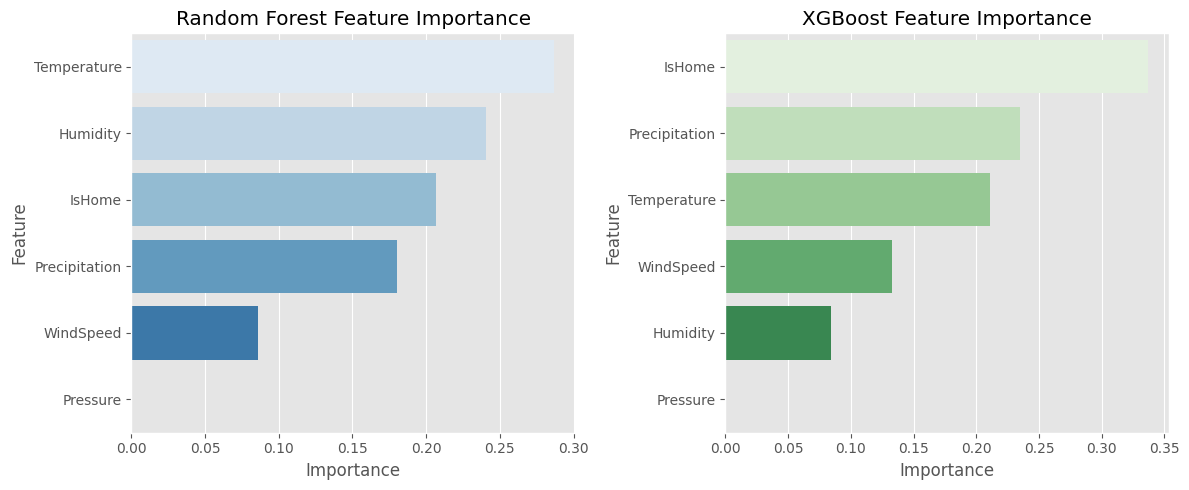

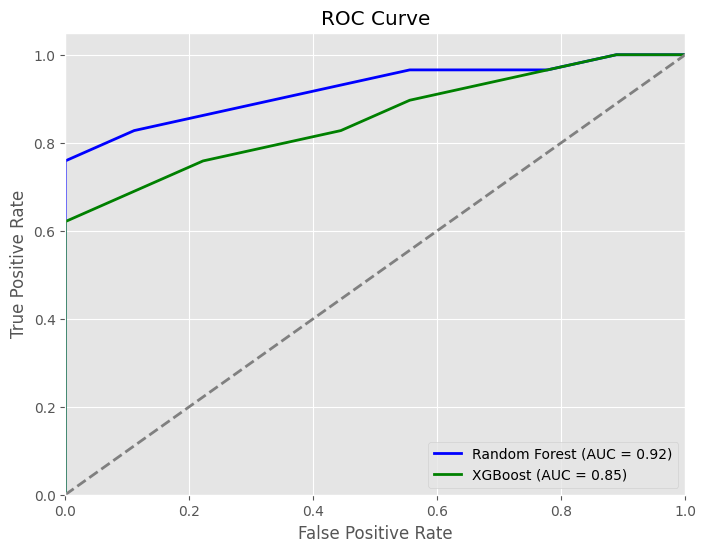

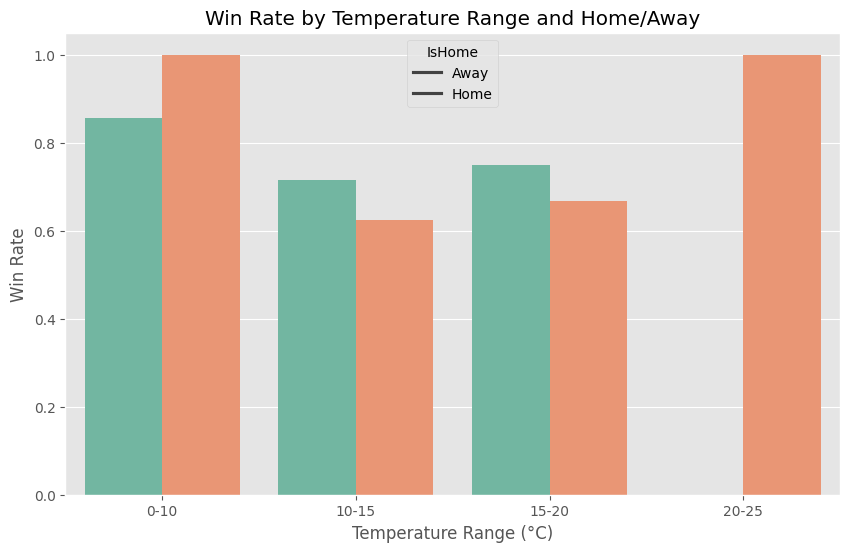

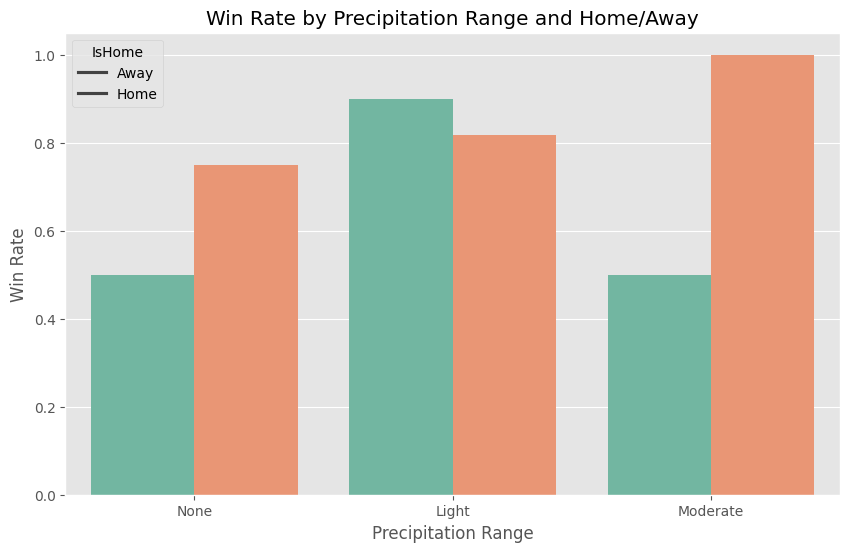

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from datetime import datetime

# Load the dataset
data = pd.read_csv('final_corrected_dataset.csv')

# Create a 'Win' column (1 for Manchester City win, 0 otherwise)
def determine_win(result):
    try:
        match = re.match(r'(.+?)\s+(\d+:\d+)\s+(.+)', result.strip())
        if not match:
            print(f"Invalid format: {result}")
            return 0
        team1, score, team2 = match.groups()
        score1, score2 = map(int, score.split(':'))
        if 'Manchester City' in team1 and score1 > score2:
            return 1
        elif 'Manchester City' in team2 and score2 > score1:
            return 1
        return 0
    except Exception as e:
        print(f"Error processing result '{result}': {e}")
        return 0

data['Win'] = data['Teams_Result'].apply(determine_win)

# Create an 'IsHome' column (1 for home games, 0 for away games)
def determine_home(result):
    try:
        match = re.match(r'(.+?)\s+\d+:\d+\s+(.+)', result.strip())
        if not match:
            return 0
        team1 = match.group(1)
        return 1 if 'Manchester City' in team1 else 0
    except Exception:
        return 0

data['IsHome'] = data['Teams_Result'].apply(determine_home)

# Aggregate data by match
match_data = data.groupby('Match_ID').agg({
    'Win': 'first',
    'IsHome': 'first',
    'Temperature': 'mean',
    'Humidity': 'mean',
    'Precipitation': 'mean',
    'WindSpeed': 'mean',
    'Pressure': 'mean'
}).reset_index()

# Check initial row count
print(f"Initial number of rows: {len(match_data)}")

# Advanced data cleaning with reasonable ranges (replace instead of drop)
weather_vars = ['Temperature', 'Humidity', 'Precipitation', 'WindSpeed', 'Pressure']
for var in weather_vars:
    mean_val = match_data[var].mean()
    if var == 'Humidity':
        match_data[var] = np.where((match_data[var] < 0) | (match_data[var] > 100), 50.0, match_data[var])  # 0-100%
    elif var == 'Pressure':
        match_data[var] = np.where((match_data[var] < 900) | (match_data[var] > 1100), 1013.25, match_data[var])  # 900-1100 hPa
    elif var == 'WindSpeed':
        match_data[var] = np.where((match_data[var] < 0) | (match_data[var] > 40), 10.0, match_data[var])  # 0-40 m/s
    elif var == 'Precipitation':
        match_data[var] = np.where((match_data[var] < 0) | (match_data[var] > 50), 0.0, match_data[var])  # 0-50 mm
    else:  # Temperature
        match_data[var] = np.where((match_data[var] < -10) | (match_data[var] > 40), mean_val, match_data[var])  # -10 to 40°C

# Check cleaned row count
print(f"Cleaned number of rows: {len(match_data)}")

# Check cleaned weather variables summary
print("\nCleaned Weather Variables Summary (Generated on {}):".format(datetime.now().strftime("%I:%M %p +04, %d %B %Y")))
print(match_data[weather_vars].describe())

# Prepare data for modeling
X = match_data[weather_vars + ['IsHome']].copy()
y = match_data['Win'].copy()

# Check for empty data
if len(X) == 0:
    raise ValueError("No data remaining after cleaning. Please check the input dataset or adjust cleaning thresholds.")

# Standardize weather variables
scaler = StandardScaler()
X[weather_vars] = scaler.fit_transform(X[weather_vars])

# Balance data using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Grid Search for Random Forest with Stratified K-Fold
rf_param_grid = {'n_estimators': [200, 300], 'max_depth': [5, 7], 'min_samples_split': [2, 5], 'max_samples': [0.8]}
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=cv, scoring='f1')
rf_grid_search.fit(X_res, y_res)
rf_best_model = rf_grid_search.best_estimator_
y_pred_rf = rf_best_model.predict(X)
y_pred_proba_rf = rf_best_model.predict_proba(X)[:, 1]

# Grid Search for XGBoost with Stratified K-Fold
xgb_param_grid = {'n_estimators': [200, 300], 'max_depth': [3, 5, 7], 'learning_rate': [0.2, 0.3, 0.5]}
xgb_grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), xgb_param_grid, cv=cv, scoring='f1')
xgb_grid_search.fit(X_res, y_res)
xgb_best_model = xgb_grid_search.best_estimator_
y_pred_xgb = xgb_best_model.predict(X)
y_pred_proba_xgb = xgb_best_model.predict_proba(X)[:, 1]

# Cross-validation scores
rf_cv_scores = cross_val_score(rf_best_model, X_res, y_res, cv=cv, scoring='f1')
xgb_cv_scores = cross_val_score(xgb_best_model, X_res, y_res, cv=cv, scoring='f1')

# Evaluate Random Forest
rf_accuracy = accuracy_score(y, y_pred_rf)
rf_conf_matrix = confusion_matrix(y, y_pred_rf)
rf_class_report = classification_report(y, y_pred_rf, zero_division=0)

# Evaluate XGBoost
xgb_accuracy = accuracy_score(y, y_pred_xgb)
xgb_conf_matrix = confusion_matrix(y, y_pred_xgb)
xgb_class_report = classification_report(y, y_pred_xgb, zero_division=0)

# Print results
print("\nRandom Forest Results (Best Params: {})".format(rf_grid_search.best_params_))
print(f"Accuracy: {rf_accuracy:.4f}")
print("\nConfusion Matrix:")
print(rf_conf_matrix)
print("\nClassification Report:")
print(rf_class_report)
print(f"Cross-Validation F1 Scores: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std() * 2:.4f})")

print("\nXGBoost Results (Best Params: {})".format(xgb_grid_search.best_params_))
print(f"Accuracy: {xgb_accuracy:.4f}")
print("\nConfusion Matrix:")
print(xgb_conf_matrix)
print("\nClassification Report:")
print(xgb_class_report)
print(f"Cross-Validation F1 Scores: {xgb_cv_scores.mean():.4f} (+/- {xgb_cv_scores.std() * 2:.4f})")

# Feature Importance
rf_feature_importance = pd.DataFrame({
    'Feature': weather_vars + ['IsHome'],
    'Importance': rf_best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

xgb_feature_importance = pd.DataFrame({
    'Feature': weather_vars + ['IsHome'],
    'Importance': xgb_best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nRandom Forest Feature Importance:")
print(rf_feature_importance)
print("\nXGBoost Feature Importance:")
print(xgb_feature_importance)

# Plot feature importance
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='Importance', y='Feature', data=rf_feature_importance, hue='Feature', palette='Blues', legend=False)
plt.title('Random Forest Feature Importance')
plt.subplot(1, 2, 2)
sns.barplot(x='Importance', y='Feature', data=xgb_feature_importance, hue='Feature', palette='Greens', legend=False)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

# Plot ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y, y_pred_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Plot win rate by temperature range
match_data['Temp_Range'] = pd.cut(
    match_data['Temperature'], 
    bins=[0, 10, 15, 20, 25], 
    labels=['0-10', '10-15', '15-20', '20-25']
)
win_rate_by_temp = match_data.groupby(['Temp_Range', 'IsHome'], observed=True)['Win'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='Temp_Range', y='Win', hue='IsHome', data=win_rate_by_temp, palette='Set2')
plt.title('Win Rate by Temperature Range and Home/Away')
plt.xlabel('Temperature Range (°C)')
plt.ylabel('Win Rate')
plt.legend(title='IsHome', labels=['Away', 'Home'])
plt.show()

# Plot win rate by precipitation
match_data['Precip_Range'] = pd.cut(
    match_data['Precipitation'], 
    bins=[0, 1, 5, 10], 
    labels=['None', 'Light', 'Moderate']
)
win_rate_by_precip = match_data.groupby(['Precip_Range', 'IsHome'], observed=True)['Win'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='Precip_Range', y='Win', hue='IsHome', data=win_rate_by_precip, palette='Set2')
plt.title('Win Rate by Precipitation Range and Home/Away')
plt.xlabel('Precipitation Range')
plt.ylabel('Win Rate')
plt.legend(title='IsHome', labels=['Away', 'Home'])
plt.show()